In [1]:
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

epochs_cnn = 20 # max epochs that will run if early stopping does not stop training
epochs_shadow = 20
epochs_tcnn = 20 # max epochs that will run if early stopping does not stop training
early_stopping= False
decimals_rounding=1
batch_size = 32

!pip install pytorch_msssim

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from pytorch_msssim import ssim, SSIM
import torchvision.transforms.functional as F
import random
import os
import random
import math
from scipy.interpolate import griddata
import copy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Architecture

In [2]:
class CNN(nn.Module):
    def __init__(self, color_channels, image_size, hidden_sizes, activation_function, hidden_linear_output, output_size):

        super(CNN, self).__init__()

        self.color_channels = color_channels
        self.image_size = image_size # single number
        self.hidden_sizes = hidden_sizes
        self.activation_function = activation_function
        self.hidden_linear_output = hidden_linear_output
        self.output_size = output_size


        self.layers = nn.ModuleList()

        for i in range(len(self.hidden_sizes)):
            self.layers.append(nn.Conv2d(self.color_channels if i ==0 else self.hidden_sizes[i-1], self.hidden_sizes[i], kernel_size=3, stride=1, padding=1))
            self.layers.append(nn.BatchNorm2d(self.hidden_sizes[i], eps=.00001, momentum=0.1, affine=True, track_running_stats=True))
            self.layers.append(nn.MaxPool2d(kernel_size=2,stride=2, padding=0, dilation=1,ceil_mode=False))
            self.layers.append(self.activation_function())
            self.image_size = int(self.image_size / 2)


        self.layers.append(nn.Flatten()) # Without this run into issues. Not included in paper why??
        self.layers.append(nn.Linear(in_features=(self.image_size**2 * self.hidden_sizes[-1]), out_features=self.hidden_linear_output, bias=True))
        self.layers.append(nn.Dropout(p=0.5))
        self.layers.append(nn.Linear(in_features=self.hidden_linear_output, out_features=self.output_size, bias=True))
        # nn.CrossEntropyLoss incorporates Softmax

    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

class TCNN(nn.Module):
    def __init__(self, input_channels, hidden_sizes, hidden_activation_func, output_color_channels):
        super(TCNN, self).__init__()
        self.input_channels = input_channels
        self.hidden_sizes = hidden_sizes
        self.hidden_activation_func = hidden_activation_func
        self.output_color_channels = output_color_channels
        self.layers = nn.ModuleList()

        for i in range(len(self.hidden_sizes)):
            #original input size is 1
            # output_size=(input_size−1)×stride−2×padding+kernel_size
            self.layers.append(nn.ConvTranspose2d(self.input_channels if i==0 else self.hidden_sizes[i-1],
                                                  self.hidden_sizes[i], kernel_size=4, stride=1 if i==0  else 2, padding=0 if i==0 else 1))
            self.layers.append(nn.BatchNorm2d(self.hidden_sizes[i], eps=.00001, momentum=0.1, affine=True, track_running_stats=True))
            self.layers.append(self.hidden_activation_func())
            self.layers.append(nn.Dropout(0.5 if i > 0 else 0.3))

        self.layers.append(nn.ConvTranspose2d(self.hidden_sizes[-1], self.output_color_channels, kernel_size=4, stride=2, padding=1))
        self.layers.append(nn.Sigmoid()) # squeeze output 0 to 1

    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

# Learning Loops

In [3]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


def loss_plot(train_loss, validation_loss):
    epochs = range(1, len(train_loss) + 1) # start at 1 instead of 0
    # Plotting the training and validation losses
    plt.figure(figsize=(5, 5))
    plt.plot(epochs, train_loss, label='Training Loss', color='blue')
    plt.plot(epochs, validation_loss, label='Validation Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def process_features(cnn, images, feature_map, x_delta, use_output_vector, use_map, use_x_delta, top_k, rounding, num_features):
    if use_output_vector:
        with torch.no_grad():
            features = cnn(images)
        if rounding:
            features = torch.round(features, decimals=rounding)
        if top_k is not None:
            top_k_values, top_k_indices = torch.topk(features, k=top_k, dim=-1)
            mask = torch.zeros_like(features, dtype=torch.bool)
            mask.scatter_(-1, top_k_indices, 1)
            features = torch.where(mask, features, torch.zeros_like(features))
    if use_map:
        features = feature_map if not use_output_vector else torch.cat((features, feature_map), dim=1)
    if use_x_delta:
        flattned_x_delta = x_delta.view(x_delta.shape[0], -1)
        features = flattned_x_delta if not (use_output_vector or use_map) else torch.cat((features, flattned_x_delta), dim=1)
    features = features.view(-1, num_features, 1, 1)
    return features

In [4]:
def train_cnn(net, train_loader, val_loader, epochs, save_as = None):
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    # Define the optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    early_stopper = EarlyStopper(patience=2, min_delta=0)

    train_loss_lst = []
    val_loss_lst = []
    f1_scores = []

    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        # Iterate over training batches
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                pbar.set_postfix({'loss': running_loss / (len(pbar) + 1)})  # Display average loss
                pbar.update(1)  # Update the progress bar
        train_loss = running_loss / len(train_loader)
        train_loss_lst.append(train_loss)

        # Validation
        net.eval()
        val_running_loss = 0.0
        true_labels = []
        predictions = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                _, preds = torch.max(outputs, 1)

                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()

                # Store predictions and true labels
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader)
        val_loss_lst.append(val_loss)
        # Calculate the F1 score
        score_f1 = f1_score(true_labels, predictions, average='weighted')  # 'weighted' accounts for class imbalance
        f1_scores.append(score_f1)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, f1 score:{score_f1:.4f}")

        # Check if validation loss meets criteria to stop learning
        if early_stopping:
            if early_stopper.early_stop(val_loss):
                print(f"Training is stopped at Epoch {epoch+1} due to early stopping")
                break

    # Save model if requested
    if save_as:
        torch.save(net, save_as)
    #display loss graph
    loss_plot(train_loss_lst, val_loss_lst)
    print("Training for CNN is finished.")
    return train_loss_lst[-1], val_loss_lst[-1], f1_scores[-1]

def training_tcnn(transposed_cnn, cnn, num_features, data_range, channels, training_dataloader, validation_dataloader, num_epochs=10,
                  top_k=None, rounding=None, use_output_vector=True, use_map=False, use_x_delta=False):
    #criterion = nn.MSELoss()
    ssim_loss = SSIM(win_size=11, win_sigma=1.5, data_range=data_range, size_average=True, channel=channels)
    optimizer = optim.Adam(transposed_cnn.parameters(), lr=0.001)
    early_stopper = EarlyStopper(patience=2, min_delta=0)

    train_loss_lst = []
    val_loss_lst = []

    cnn.eval()

    # Training loop
    for epoch in range(num_epochs):
        transposed_cnn.train()  # Set the model to training mode
        running_loss = 0.0

        for images, labels, feature_map, x_delta in training_dataloader:
            images, labels, feature_map, x_delta = images.to(device), labels.to(device), feature_map.to(device), x_delta.to(device)
            features = process_features(cnn, images, feature_map, x_delta, use_output_vector, use_map, use_x_delta, top_k, rounding, num_features)
            optimizer.zero_grad()
            reconstructed_images = transposed_cnn(features)
            loss = 1 - ssim_loss(reconstructed_images, images) # return a scalar
            loss.backward(retain_graph=True)
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(training_dataloader)
        train_loss_lst.append(train_loss)

        # Validation evaluation
        transposed_cnn.eval()
        val_running_loss = 0.0

        with torch.no_grad():
            for images, labels, feature_map, x_delta in validation_dataloader:
                images, labels, feature_map, x_delta = images.to(device), labels.to(device), feature_map.to(device), x_delta.to(device)
                features = process_features(cnn, images, feature_map, x_delta, use_output_vector, use_map, use_x_delta, top_k, rounding, num_features)
                reconstructed_images = transposed_cnn(features)
                loss = 1 - ssim_loss(reconstructed_images, images) # return a scalar

                val_running_loss += loss.item()

        val_loss = val_running_loss / len(validation_dataloader)
        val_loss_lst.append(val_loss)

        # Check if validation loss meets criteria to stop learning
        if early_stopping:
            if early_stopper.early_stop(val_loss):
                print(f"Training is stopped at Epoch {epoch+1} due to early stopping")
                break

    # Print only the last epoch's training and validation loss
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_lst[-1]:.4f}, Val Loss: {val_loss_lst[-1]:.4f}")

    # loss_plot(train_loss_lst, val_loss_lst)
    # print("Training for TCNN is finished.")

# Data Setup

Training set size: 20000
Testing set size: 4000
torch.Size([32, 1, 32, 32])
Image shape: torch.Size([32, 32, 1])


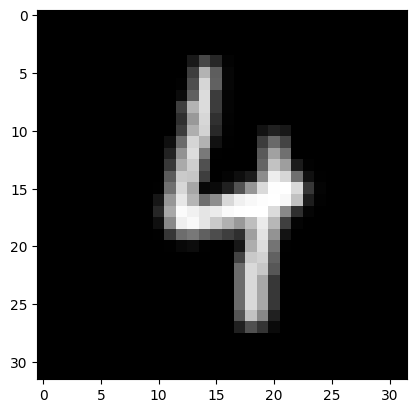

Image shape: torch.Size([32, 32, 1])


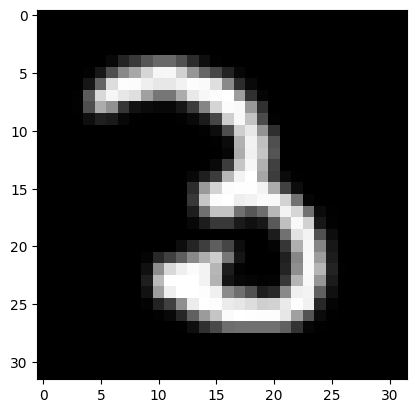

Total number of images: 10000


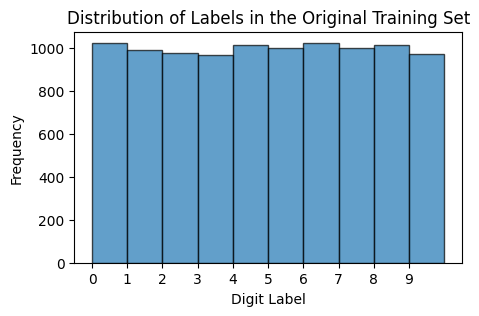

Total number of images: 10000


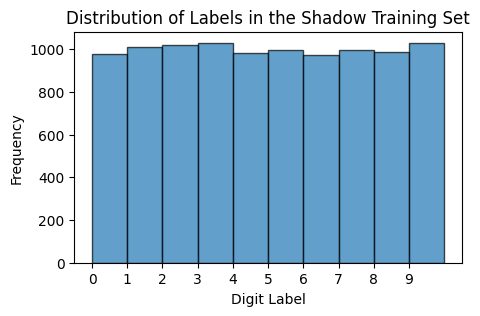

Total number of images: 1340


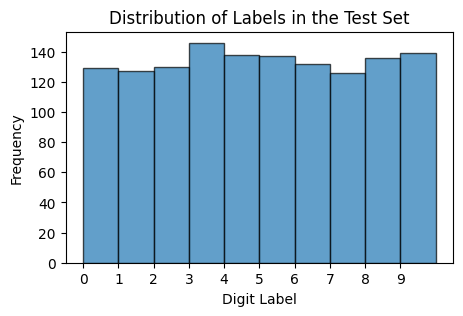

Total number of images validation target set: 1320
Total number of images validation shadow set: 1340


In [5]:

root = './data'  # Adjust if desired

transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),  # Convert images to tensors
    #transforms.Normalize((0,), (1/255,))  # Normalize pixel values
])

train_dataset = datasets.MNIST(root=root, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=root, train=False, download=True, transform=transform)

def split_dataset(dataset, num_samples_per_class):
    subset_indices = []

    class_indices = {i: [] for i in range(10)}  # Dictionary to store indices for each class
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    for indices in class_indices.values(): # Get N from each class randomly without replacement
        selected_indices = np.random.choice(indices, num_samples_per_class, replace=False)
        subset_indices.extend(selected_indices)

    return Subset(dataset, subset_indices)

# Create the custom training and testing sets
train_dataset = split_dataset(train_dataset, 2000) # 1 thousand per class = 20,000
test_dataset = split_dataset(test_dataset, 400) # 200 per class = 4,000

# Verify the new datasets
print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")


# Split the train dataset into original and shadow sets
original_size = int(0.5 * len(train_dataset))
shadow_size = len(train_dataset) - original_size
original_dataset, shadow_dataset = torch.utils.data.random_split(train_dataset, [original_size, shadow_size])

# Split the test dataset into orginial, shadow validations and test set
val__org_size = int(0.33 * len(test_dataset))
remaining_size = len(test_dataset) - val__org_size
val_org_dataset, remaining_dataset = torch.utils.data.random_split(test_dataset, [val__org_size, remaining_size])
val_shad_size = int(0.5 * len(remaining_dataset))
test_size = len(remaining_dataset) - val_shad_size
val_shad_dataset, test_dataset = torch.utils.data.random_split(remaining_dataset, [val_shad_size, test_size])

# Create dataloaders
original_loader = DataLoader(original_dataset, batch_size=batch_size, shuffle=True)
shadow_loader = DataLoader(shadow_dataset, batch_size=batch_size, shuffle=True)
org_val_loader = DataLoader(val_org_dataset, batch_size=batch_size, shuffle=False)
shad_val_loader = DataLoader(val_shad_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

try:
    images, labels = next(iter(original_loader))
    print(images.shape)

    for i in range(2):#(len(images)):
        image = images[i].permute(1, 2, 0)  # Ensure image is in the correct format for display
        print("Image shape:", image.shape)

        # Display the image
        plt.imshow(image, cmap='gray')
        plt.show()

except Exception as e:
    print("An error occurred:", e)


# Plot the distribution of labels in the training set
plt.figure(figsize=(5, 3))
labels = [label for _, label in original_dataset]
print(f"Total number of images: {len(labels)}")
plt.hist(labels, bins=range(11), edgecolor='black', alpha=0.7)
plt.xticks(range(10))
plt.xlabel('Digit Label')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in the Original Training Set')
plt.show()

plt.figure(figsize=(5, 3))
labels = [label for _, label in shadow_dataset]
print(f"Total number of images: {len(labels)}")
plt.hist(labels, bins=range(11), edgecolor='black', alpha=0.7)
plt.xticks(range(10))
plt.xlabel('Digit Label')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in the Shadow Training Set')
plt.show()

plt.figure(figsize=(5, 3))
labels = [label for _, label in test_dataset]
print(f"Total number of images: {len(labels)}")
plt.hist(labels, bins=range(11), edgecolor='black', alpha=0.7)
plt.xticks(range(10))
plt.xlabel('Digit Label')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in the Test Set')
plt.show()

labels = [label for _, label in val_org_dataset]
print(f"Total number of images validation target set: {len(labels)}")
labels = [label for _, label in val_shad_dataset]
print(f"Total number of images validation shadow set: {len(labels)}")

# Experiment for Activation and Dropout between Linear Layers CNN

In [23]:
def train_cnn_compressed_output(net, train_loader, val_loader, epochs, save_as = None):
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    # Define the optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    early_stopper = EarlyStopper(patience=2, min_delta=0)

    train_loss_lst = []
    val_loss_lst = []
    f1_scores = []

    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        # Iterate over training batches
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_loss_lst.append(train_loss)

        # Validation
        net.eval()
        val_running_loss = 0.0
        true_labels = []
        predictions = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                _, preds = torch.max(outputs, 1)

                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()

                # Store predictions and true labels
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader)
        val_loss_lst.append(val_loss)
        # Calculate the F1 score
        score_f1 = f1_score(true_labels, predictions, average='weighted')  # 'weighted' accounts for class imbalance
        f1_scores.append(score_f1)

        # Check if validation loss meets criteria to stop learning
        if early_stopping:
            if early_stopper.early_stop(val_loss):
                print(f"Training is stopped at Epoch {epoch+1} due to early stopping")
                break

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss_lst[-1]:.4f}, Val Loss: {val_loss_lst[-1]:.4f}, f1 score: {f1_scores[-1]:.4f}")
    # Save model if requested
    if save_as:
        torch.save(net, save_as)

    #display loss graph
    loss_plot(train_loss_lst, val_loss_lst)
    print("Training for CNN is finished.")
    return train_loss_lst[-1], val_loss_lst[-1], f1_scores[-1]

class CNN_testing(nn.Module):
    def __init__(self, color_channels, image_size, hidden_sizes, activation_function, hidden_linear_output, output_size, inc_dropout=True, ac_func=None):

        super(CNN_testing, self).__init__()

        self.color_channels = color_channels
        self.image_size = image_size # single number
        self.hidden_sizes = hidden_sizes
        self.activation_function = activation_function
        self.hidden_linear_output = hidden_linear_output
        self.output_size = output_size


        self.layers = nn.ModuleList()

        for i in range(len(self.hidden_sizes)):
            self.layers.append(nn.Conv2d(self.color_channels if i ==0 else self.hidden_sizes[i-1], self.hidden_sizes[i], kernel_size=3, stride=1, padding=1))
            self.layers.append(nn.BatchNorm2d(self.hidden_sizes[i], eps=.00001, momentum=0.1, affine=True, track_running_stats=True))
            self.layers.append(nn.MaxPool2d(kernel_size=2,stride=2, padding=0, dilation=1,ceil_mode=False))
            self.layers.append(self.activation_function())
            self.image_size = int(self.image_size / 2)


        self.layers.append(nn.Flatten()) # Without this run into issues. Not included in paper why??
        self.layers.append(nn.Linear(in_features=(self.image_size**2 * self.hidden_sizes[-1]), out_features=self.hidden_linear_output, bias=True))
        if inc_dropout:
            self.layers.append(nn.Dropout(p=0.5))
        if ac_func != None:
            self.layers.append(ac_func())
        self.layers.append(nn.Linear(in_features=self.hidden_linear_output, out_features=self.output_size, bias=True))
        # nn.CrossEntropyLoss incorporates Softmax

    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

In [24]:
def run_cnn_experiment(models_configs, num_repeats):
    all_results = {config['name']: {'f1': [], 'train_loss': [], 'val_loss': []} for config in models_configs}
    for i in range(num_repeats):
        for config in models_configs:
            name = config['name']
            print(f"name {name}. iteration {i+1}")

            dropout_bool = config['dropout_bool']
            ac_func = config['ac_func']

            cnn_model = CNN_testing(color_channels=1, image_size=32, hidden_sizes=[128,256,512],
                     activation_function=nn.ReLU, hidden_linear_output=50,output_size=10, inc_dropout=dropout_bool, ac_func=ac_func).to(device)

            loss_train, loss_val, score_f1 = train_cnn_compressed_output(cnn_model, original_loader, org_val_loader, epochs_cnn)

            all_results[config['name']]['f1'].append(score_f1)
            all_results[config['name']]['train_loss'].append(loss_train)
            all_results[config['name']]['val_loss'].append(loss_val)

    for config in models_configs:
        name = config['name']
        mean_f1 = np.mean(all_results[name]['f1'])
        std_f1 = np.std(all_results[name]['f1'])
        mean_train_loss = np.mean(all_results[name]['train_loss'])
        std_train_loss = np.std(all_results[name]['train_loss'])
        mean_val_loss = np.mean(all_results[name]['val_loss'])
        std_val_loss = np.std(all_results[name]['val_loss'])
        print(f'{name}: Average f1 on val set: {round(mean_f1, 4)} ± {round(std_f1, 4)}, '
              f'Average train_loss on val set: {round(mean_train_loss, 4)} ± {round(std_train_loss, 4)}, '
              f'Average val_loss on val set: {round(mean_val_loss, 4)} ± {round(std_val_loss, 4)}')

models_configs = [
    {'name': 'None + No', 'ac_func': None, 'dropout_bool': False},
    {'name': 'None + Yes', 'ac_func': None, 'dropout_bool': True},
    {'name': 'ReLU + No', 'ac_func': nn.ReLU, 'dropout_bool': False},
    {'name': 'ReLU + Yes', 'ac_func': nn.ReLU, 'dropout_bool': True},
    {'name': 'Sigmoid + No', 'ac_func': nn.Sigmoid, 'dropout_bool': False},
    {'name': 'Sigmoid + Yes', 'ac_func': nn.Sigmoid, 'dropout_bool': True},
    {'name': 'GELU + No', 'ac_func': nn.GELU, 'dropout_bool': False},
    {'name': 'GELU + Yes', 'ac_func': nn.GELU, 'dropout_bool': True},
    {'name': 'Swish + No', 'ac_func': nn.SiLU, 'dropout_bool': False},
    {'name': 'Swish + Yes', 'ac_func': nn.SiLU, 'dropout_bool': True},
]

run_cnn_experiment(models_configs, num_repeats=5) #1.25 hours

# Target CNN's and Shadow CNNs

In [6]:
def cf_creation(model, validation_loader, title_txt=""):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Make predictions
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Collect predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(7, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title_txt)
    plt.show()

    return conf_matrix

Epoch 1/20: 100%|██████████| 313/313 [00:05<00:00, 60.60batch/s, loss=0.634]


Epoch 1/20, Train Loss: 0.6357, Val Loss: 0.2796, f1 score:0.9310


Epoch 2/20: 100%|██████████| 313/313 [00:04<00:00, 67.08batch/s, loss=0.204] 


Epoch 2/20, Train Loss: 0.2047, Val Loss: 0.1359, f1 score:0.9647


Epoch 3/20: 100%|██████████| 313/313 [00:04<00:00, 69.82batch/s, loss=0.138] 


Epoch 3/20, Train Loss: 0.1388, Val Loss: 0.0657, f1 score:0.9841


Epoch 4/20: 100%|██████████| 313/313 [00:04<00:00, 66.31batch/s, loss=0.109] 


Epoch 4/20, Train Loss: 0.1093, Val Loss: 0.0741, f1 score:0.9803


Epoch 5/20: 100%|██████████| 313/313 [00:05<00:00, 60.17batch/s, loss=0.0794]


Epoch 5/20, Train Loss: 0.0796, Val Loss: 0.0674, f1 score:0.9794


Epoch 6/20: 100%|██████████| 313/313 [00:04<00:00, 67.92batch/s, loss=0.0728]


Epoch 6/20, Train Loss: 0.0731, Val Loss: 0.0343, f1 score:0.9879


Epoch 7/20: 100%|██████████| 313/313 [00:04<00:00, 68.02batch/s, loss=0.0491]


Epoch 7/20, Train Loss: 0.0493, Val Loss: 0.0321, f1 score:0.9917


Epoch 8/20: 100%|██████████| 313/313 [00:04<00:00, 66.55batch/s, loss=0.0501]


Epoch 8/20, Train Loss: 0.0503, Val Loss: 0.0347, f1 score:0.9902


Epoch 9/20: 100%|██████████| 313/313 [00:04<00:00, 62.83batch/s, loss=0.0355] 


Epoch 9/20, Train Loss: 0.0356, Val Loss: 0.0370, f1 score:0.9917


Epoch 10/20: 100%|██████████| 313/313 [00:04<00:00, 68.65batch/s, loss=0.0545]


Epoch 10/20, Train Loss: 0.0547, Val Loss: 0.0605, f1 score:0.9834


Epoch 11/20: 100%|██████████| 313/313 [00:04<00:00, 65.31batch/s, loss=0.0489]


Epoch 11/20, Train Loss: 0.0490, Val Loss: 0.0441, f1 score:0.9864


Epoch 12/20: 100%|██████████| 313/313 [00:05<00:00, 59.97batch/s, loss=0.034] 


Epoch 12/20, Train Loss: 0.0341, Val Loss: 0.0431, f1 score:0.9901


Epoch 13/20: 100%|██████████| 313/313 [00:05<00:00, 60.92batch/s, loss=0.0301] 


Epoch 13/20, Train Loss: 0.0302, Val Loss: 0.0706, f1 score:0.9804


Epoch 14/20: 100%|██████████| 313/313 [00:05<00:00, 62.00batch/s, loss=0.0289]


Epoch 14/20, Train Loss: 0.0290, Val Loss: 0.0485, f1 score:0.9894


Epoch 15/20: 100%|██████████| 313/313 [00:04<00:00, 63.14batch/s, loss=0.0249] 


Epoch 15/20, Train Loss: 0.0250, Val Loss: 0.0414, f1 score:0.9879


Epoch 16/20: 100%|██████████| 313/313 [00:04<00:00, 69.89batch/s, loss=0.0279]


Epoch 16/20, Train Loss: 0.0280, Val Loss: 0.0553, f1 score:0.9871


Epoch 17/20: 100%|██████████| 313/313 [00:05<00:00, 60.79batch/s, loss=0.02]   


Epoch 17/20, Train Loss: 0.0201, Val Loss: 0.0603, f1 score:0.9902


Epoch 18/20: 100%|██████████| 313/313 [00:04<00:00, 63.48batch/s, loss=0.0213] 


Epoch 18/20, Train Loss: 0.0214, Val Loss: 0.0693, f1 score:0.9864


Epoch 19/20: 100%|██████████| 313/313 [00:04<00:00, 63.60batch/s, loss=0.0271]


Epoch 19/20, Train Loss: 0.0272, Val Loss: 0.0480, f1 score:0.9863


Epoch 20/20: 100%|██████████| 313/313 [00:04<00:00, 66.26batch/s, loss=0.0239] 


Epoch 20/20, Train Loss: 0.0239, Val Loss: 0.0420, f1 score:0.9886


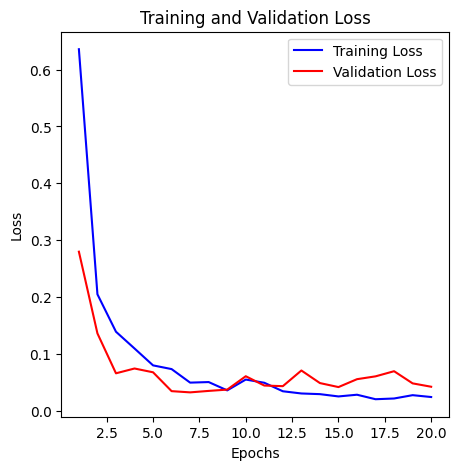

Training for CNN is finished.


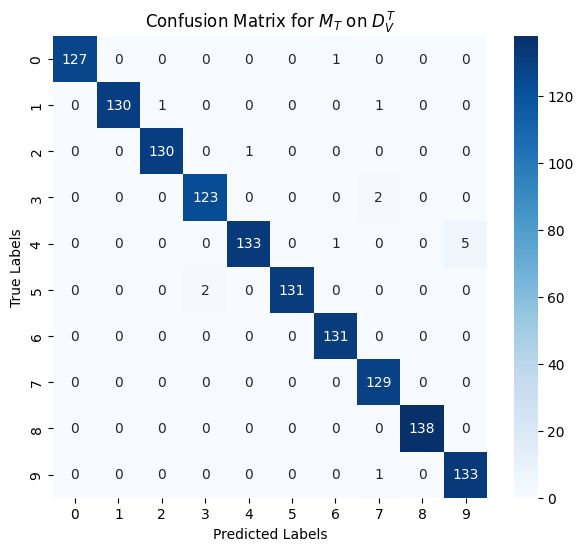

In [10]:
target_model = CNN(color_channels=1, image_size=32, hidden_sizes=[128,256,512],
                     activation_function=nn.ReLU, hidden_linear_output=50,output_size=10).to(device)
loss_train_t, loss_val_t, f1_t = train_cnn(target_model, original_loader, org_val_loader, epochs_cnn)
matrix_target = cf_creation(target_model, org_val_loader, r"Confusion Matrix for $M_{T}$ on $D^{T}_{V}$")

Epoch 1/20: 100%|██████████| 313/313 [00:04<00:00, 63.53batch/s, loss=0.648]


Epoch 1/20, Train Loss: 0.6498, Val Loss: 0.1163, f1 score:0.9658


Epoch 2/20: 100%|██████████| 313/313 [00:05<00:00, 61.85batch/s, loss=0.19]  


Epoch 2/20, Train Loss: 0.1903, Val Loss: 0.1242, f1 score:0.9678


Epoch 3/20: 100%|██████████| 313/313 [00:04<00:00, 66.66batch/s, loss=0.147] 


Epoch 3/20, Train Loss: 0.1472, Val Loss: 0.0793, f1 score:0.9791


Epoch 4/20: 100%|██████████| 313/313 [00:05<00:00, 61.57batch/s, loss=0.0962]


Epoch 4/20, Train Loss: 0.0965, Val Loss: 0.1037, f1 score:0.9693


Epoch 5/20: 100%|██████████| 313/313 [00:04<00:00, 67.43batch/s, loss=0.0819]


Epoch 5/20, Train Loss: 0.0821, Val Loss: 0.0696, f1 score:0.9799


Epoch 6/20: 100%|██████████| 313/313 [00:04<00:00, 65.43batch/s, loss=0.0677]


Epoch 6/20, Train Loss: 0.0679, Val Loss: 0.0816, f1 score:0.9791


Epoch 7/20: 100%|██████████| 313/313 [00:05<00:00, 60.40batch/s, loss=0.0556]


Epoch 7/20, Train Loss: 0.0557, Val Loss: 0.1118, f1 score:0.9723


Epoch 8/20: 100%|██████████| 313/313 [00:04<00:00, 65.38batch/s, loss=0.0716]


Epoch 8/20, Train Loss: 0.0719, Val Loss: 0.1010, f1 score:0.9776


Epoch 9/20: 100%|██████████| 313/313 [00:04<00:00, 63.11batch/s, loss=0.0337] 


Epoch 9/20, Train Loss: 0.0338, Val Loss: 0.0648, f1 score:0.9843


Epoch 10/20: 100%|██████████| 313/313 [00:04<00:00, 66.37batch/s, loss=0.0379] 


Epoch 10/20, Train Loss: 0.0381, Val Loss: 0.0651, f1 score:0.9843


Epoch 11/20: 100%|██████████| 313/313 [00:04<00:00, 62.89batch/s, loss=0.0485]


Epoch 11/20, Train Loss: 0.0486, Val Loss: 0.0507, f1 score:0.9881


Epoch 12/20: 100%|██████████| 313/313 [00:04<00:00, 65.63batch/s, loss=0.0395]


Epoch 12/20, Train Loss: 0.0396, Val Loss: 0.0912, f1 score:0.9798


Epoch 13/20: 100%|██████████| 313/313 [00:04<00:00, 66.63batch/s, loss=0.0339]


Epoch 13/20, Train Loss: 0.0340, Val Loss: 0.0690, f1 score:0.9836


Epoch 14/20: 100%|██████████| 313/313 [00:04<00:00, 69.07batch/s, loss=0.0224] 


Epoch 14/20, Train Loss: 0.0225, Val Loss: 0.0654, f1 score:0.9806


Epoch 15/20: 100%|██████████| 313/313 [00:04<00:00, 64.36batch/s, loss=0.0264] 


Epoch 15/20, Train Loss: 0.0264, Val Loss: 0.1109, f1 score:0.9820


Epoch 16/20: 100%|██████████| 313/313 [00:05<00:00, 62.15batch/s, loss=0.0301] 


Epoch 16/20, Train Loss: 0.0302, Val Loss: 0.0641, f1 score:0.9843


Epoch 17/20: 100%|██████████| 313/313 [00:04<00:00, 63.26batch/s, loss=0.0244] 


Epoch 17/20, Train Loss: 0.0245, Val Loss: 0.0682, f1 score:0.9843


Epoch 18/20: 100%|██████████| 313/313 [00:04<00:00, 63.36batch/s, loss=0.0204] 


Epoch 18/20, Train Loss: 0.0205, Val Loss: 0.1082, f1 score:0.9821


Epoch 19/20: 100%|██████████| 313/313 [00:05<00:00, 62.16batch/s, loss=0.02]   


Epoch 19/20, Train Loss: 0.0201, Val Loss: 0.0765, f1 score:0.9836


Epoch 20/20: 100%|██████████| 313/313 [00:05<00:00, 61.58batch/s, loss=0.0278]


Epoch 20/20, Train Loss: 0.0279, Val Loss: 0.0668, f1 score:0.9866


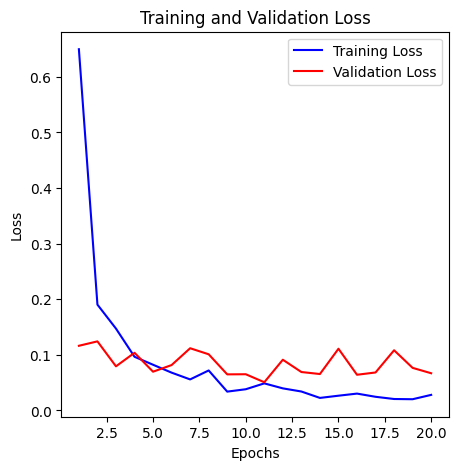

Training for CNN is finished.


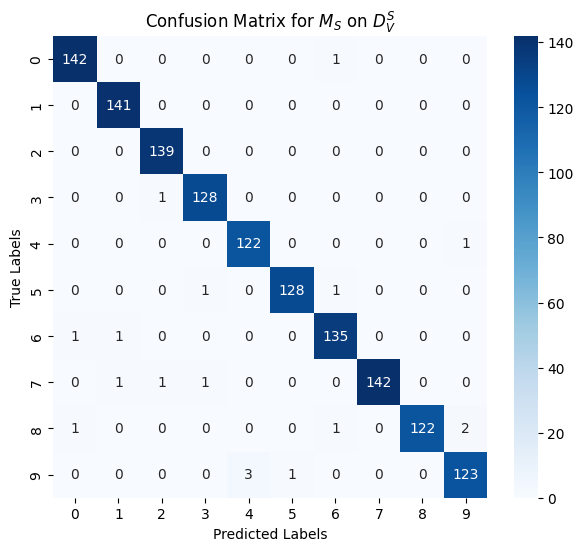

In [8]:
shadow_model = CNN(color_channels=1, image_size=32, hidden_sizes=[128,256,512],
                     activation_function=nn.ReLU, hidden_linear_output=50,output_size=10).to(device)
loss_train_t, loss_val_t, f1_t = train_cnn(shadow_model, shadow_loader, shad_val_loader, epochs_shadow)
matrix_shadow = cf_creation(shadow_model, shad_val_loader, r"Confusion Matrix for $M_{S}$ on $D^{S}_{V}$")

In [11]:
shadow_model.eval()
layer_weights = shadow_model.layers[15].weight.detach().clone().to(device)
layer_bias = shadow_model.layers[15].bias.detach().clone().to(device)

In [29]:
# torch.save(target_model, '/content/drive/My Drive/Thesis_shared/v2/target_model.pth')
# torch.save(shadow_model, '/content/drive/My Drive/Thesis_shared/v2/shadow_model.pth')
# target_model = torch.load('/content/drive/My Drive/Thesis_shared/v2/target_model.pth')
# shadow_model = torch.load('/content/drive/My Drive/Thesis_shared/v2/shadow_model.pth')

# Linear Activations & Grad Reconstructions Hyperparameter Tuning and Exploration

In [13]:
def display_class_dictionary(images_dict):
    # Set up the plot
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(5, 3))
    axes = axes.flatten()

    for idx, (ax, (class_id, image_tensor)) in enumerate(zip(axes, images_dict.items())):
        img = image_tensor.detach().cpu().squeeze()
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Class {class_id}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def average_image_per_class(image_dataset):
    sum_images = {}
    count_images = {}
    average_images = {i: None for i in range(10)}
    for image_tensor, label in image_dataset:
        if label not in sum_images:
            sum_images[label] = torch.zeros_like(image_tensor, dtype=torch.float32)
            count_images[label] = 0
        sum_images[label] += image_tensor.float()
        count_images[label] += 1

    for label, sum_image in sum_images.items():
        average_images[label] = sum_image / count_images[label]

    return average_images

def fill_class_images(image_dataset):
    '''get specific class instance per class'''
    class_images = {i: None for i in range(10)}  # Initialize dictionary for classes 0-10 with None values

    for images, labels in image_dataset:
        if class_images[labels] is None:
            class_images[labels] = images
        # Check if all classes have images assigned
        if all(image is not None for image in class_images.values()):
            break

    return class_images

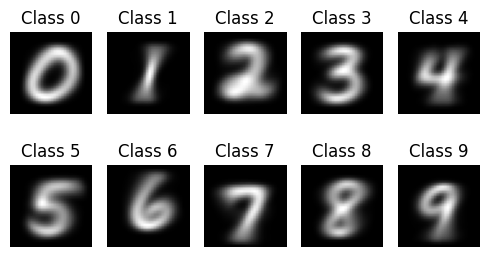

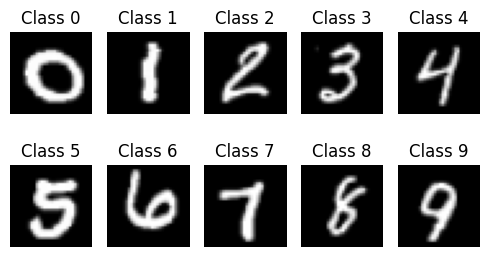

In [14]:
# Get Dictionary for Average Images
average_images_dict = average_image_per_class(shadow_dataset)
display_class_dictionary(average_images_dict)

# Get Dictionary for Class Instance Images
number_dict = fill_class_images(shadow_dataset)
display_class_dictionary(number_dict)

plotting functions

In [15]:
def plot_delta_x_vs_real(x_delta_tensor, target_tensor, images_indices=[5,12,20,4,45]):
    '''To display Target vs Reconstructed images'''

    fig, axes = plt.subplots(nrows=1, ncols=len(images_indices), figsize=(10, 3))  # Adjust figsize as needed
    fig.suptitle('Delta X Images')

    p = 0
    for i in images_indices:
        ax = axes[p]
        img = x_delta_tensor[i].detach().cpu().squeeze()
        ax.imshow(img, cmap='gray')
        ax.set_axis_off()
        p+=1

    plt.show()

    fig, axes = plt.subplots(nrows=1, ncols=len(images_indices), figsize=(10, 3))  # Adjust figsize as needed
    fig.suptitle('Original Images')

    p=0
    for i in images_indices:
        ax = axes[p]
        img = target_tensor[i].detach().cpu().squeeze()
        ax.imshow(img, cmap='gray')
        ax.set_axis_off()
        p+=1
    plt.show()

def plot_search(results, x_str, y_str, res_str, scale=False):
    '''for Grid Search'''
    # Assuming coarse_results is a list of dictionaries with 'lr', 'hidden_size', 'val_loss', and 'accuracy'
    # Extract relevant information for the heatmap
    lr_values = [result[x_str] for result in results]
    hidden_size_values = [result[y_str] for result in results]
    val_loss_values = [result[res_str] for result in results]

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.scatter(lr_values, hidden_size_values, c=val_loss_values, cmap='RdYlGn', marker='o', s=100)
    plt.colorbar(heatmap, label=res_str)
    if scale:
        plt.xscale('log')  # Use a logarithmic scale for learning rates if appropriate
        plt.yscale('log')

    # Set labels and title
    plt.xlabel(x_str)
    plt.ylabel(y_str)
    plt.title('Hyperparameter Search')
    plt.grid(True)

    # Show the plot
    plt.show()

Gradient Reconstructions functions

In [16]:
def get_similar_images(target_outputs, class_images_dict):
    '''function that for a given batch of output vectors (from CNN) returns image from class dictionary'''
    predicted_classes = torch.argmax(target_outputs, axis=1)

    similar_images = [class_images_dict[pred.item()] for pred in predicted_classes]
    return torch.stack(similar_images)

def total_variation_loss(batch_img):
    """Calculate the Total Variation Loss for a batch of single-channel images."""
    pixel_diff_x = batch_img[:, :, :-1, :] - batch_img[:, :, 1:, :]
    pixel_diff_y = batch_img[:, :, :, :-1] - batch_img[:, :, :, 1:]
    tv_loss = torch.sum(torch.abs(pixel_diff_x)) + torch.sum(torch.abs(pixel_diff_y))
    return tv_loss

def x_delta_reconstruction(target_outputs, batch_size, number_dict, average_images_dict, lr=0.01, lambda_reg_l2=0.002, lambda_reg_tv=0.0001, iterations=600, inilization='Average_Image'):
    '''Do actual Gradient Reconstructions'''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if inilization == "Average_Image":
        initial_tensors = get_similar_images(target_outputs, average_images_dict).to(device)
        initial_tensors.requires_grad_(True)
    elif inilization == "Example_Image":
        initial_tensors = get_similar_images(target_outputs, number_dict).to(device)
        initial_tensors.requires_grad_(True)
    else:
        initial_tensors = torch.rand(batch_size, 1, 32, 32, device=device, requires_grad=True)

    loss_fn = nn.MSELoss()
    optimizer = optim.Adam([initial_tensors], lr=lr)
    
    
    shadow_model.eval()
    for iteration in range(iterations):
        optimizer.zero_grad()
        outputs = shadow_model(initial_tensors) # always pass image to optimize through Shadow model
        loss = loss_fn(outputs, target_outputs)

        reg_loss_l2 = lambda_reg_l2 * torch.sum(initial_tensors ** 2)
        reg_loss_tv = lambda_reg_tv * total_variation_loss(initial_tensors)

        total_loss = loss + reg_loss_l2 + reg_loss_tv
        total_loss.backward()

        torch.nn.utils.clip_grad_norm_(initial_tensors, max_norm=1.0)
        optimizer.step()

        initial_tensors.data.clamp_(0, 1)

        # if iteration % 100 == 0:
        #     print(f'Iteration {iteration}, Loss: {loss.item()}')


    return initial_tensors

def delta_x_testing(lr, lambda_reg_l2, lambda_reg_tv, iterations, num_batches, number_dict, average_images_dict,
                    loader=shadow_loader, cnn=shadow_model, inilization='Average_Image'):
    '''Used for Running Gradient Reconstructions with different hyperparameters and then providing the SSIM and MSE values across num_batches'''
    cnn.eval()
    i=0
    x_delta_list = []
    images_list = []
    ssim_values = [] # stores average values over batch
    mse_values = [] # stores average values over batch
    labels_lst = []

    criterion = SSIM(win_size=11, win_sigma=1.5, data_range=1, size_average=True, channel=1)
    criterion2 = SSIM(win_size=11, win_sigma=1.5, data_range=1, size_average=False, channel=1)
    mse_loss = nn.MSELoss()

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        labels_lst.extend(labels.tolist())
        with torch.no_grad():
            target_outputs = cnn(images) # Obtain target output to compare with. Training use Shadow CNN for testing use Target CNN to obtain outputs

        # obtain x_deltas
        x_deltas = x_delta_reconstruction(target_outputs, images.shape[0],number_dict,average_images_dict, lr, lambda_reg_l2, lambda_reg_tv, iterations, inilization=inilization) # function above
        x_delta_list.append(x_deltas.detach().cpu())
        images_list.append(images.detach().cpu())

        #SSIM and MSE to identify best hyperparameters
        with torch.no_grad():
            # individual values for each image
            ssim_batch = criterion2(x_deltas.to('cpu'), images.to('cpu'))
            mse_batch = [mse_loss(x_deltas[j].to('cpu'), images[j].to('cpu')).item() for j in range(images.shape[0])]

            ssim_values.extend(ssim_batch)
            mse_values.extend(mse_batch)

        #break conditions
        i+=1
        if i!=None and i == num_batches:
            break

    x_delta_tensor = torch.cat(x_delta_list, dim=0)
    images_tensor = torch.cat(images_list, dim=0)

    # Get {class: (SSIM, Index)}
    highest_ssim_per_class = {cls: (float('-inf'), 0) for cls in range(10)}
    for idx, (cls, ssim) in enumerate(zip(labels_lst, ssim_values)):
        if ssim > highest_ssim_per_class[cls][0]:
            highest_ssim_per_class[cls] = (ssim, idx)

    # get the index for max ssim value per class
    highest_ssim_indices = [highest_ssim_per_class[cls][1] for cls in highest_ssim_per_class]

    return np.mean(ssim_values), np.mean(mse_values), x_delta_tensor, images_tensor, highest_ssim_indices

grid search

1. L2: 0.0007792209871551371 and variation_loss: 5.076517182343858e-06
	SSIM: 0.12103
	MSE loss: 0.091051

2. L2: 0.02275107760017204 and variation_loss: 0.001419308157842184
	SSIM: 0.13213
	MSE loss: 0.072271

3. L2: 6.40372257770517e-05 and variation_loss: 1.091056179757757e-05
	SSIM: 0.18306
	MSE loss: 0.11826

4. L2: 1.1447535068239608e-05 and variation_loss: 8.969131462516129e-06
	SSIM: 0.20548
	MSE loss: 0.11053

5. L2: 4.980323883448591e-05 and variation_loss: 0.006231352631279003
	SSIM: 0.2504
	MSE loss: 0.064799

6. L2: 0.00019573233135299455 and variation_loss: 0.0044372750851128535
	SSIM: 0.22936
	MSE loss: 0.070309

7. L2: 7.512812983137927e-05 and variation_loss: 0.00027227788028834403
	SSIM: 0.21883
	MSE loss: 0.091592

8. L2: 0.0006681318545684919 and variation_loss: 2.6613724269762374e-06
	SSIM: 0.14313
	MSE loss: 0.098069

9. L2: 0.00048387783743750635 and variation_loss: 2.0571720420036477e-06
	SSIM: 0.13092
	MSE loss: 0.099842

10. L2: 0.00011456271291314557 and vari

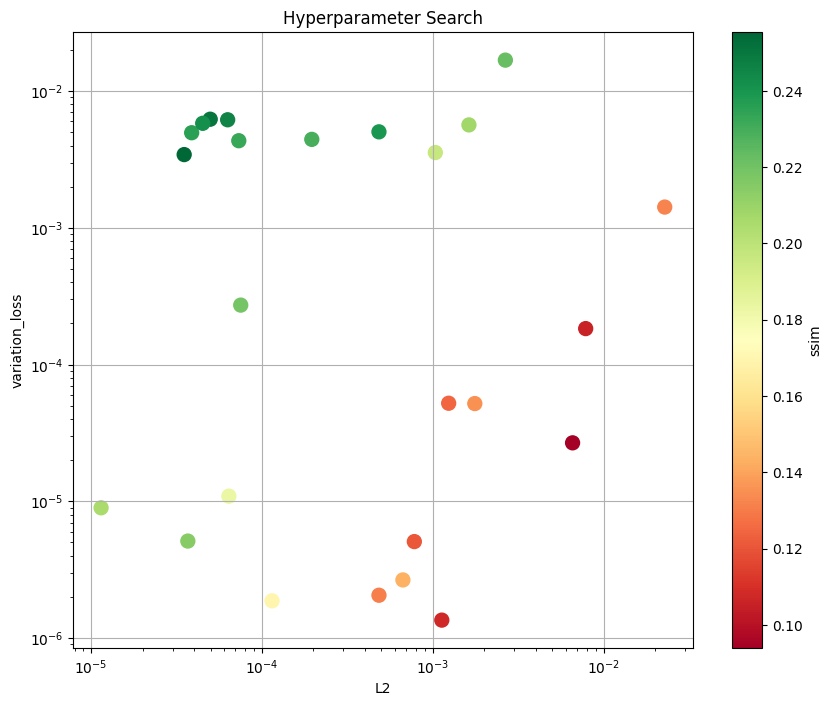

In [54]:
# Coarse Random Search
coarse_trials = 20
num_batches = 3
coarse_results = []

for i in range(coarse_trials):
    lambda_reg_l2 = 10**random.uniform(math.log10(0.00001), math.log10(0.03))
    lambda_reg_tv = 10**random.uniform(math.log10(0.000001), math.log10(0.03))

    ssim, mse, x_ds, imgs, _ = delta_x_testing(0.01, lambda_reg_l2, lambda_reg_tv, 400, num_batches, number_dict, average_images_dict
                                            ,cnn=target_model) #, inilization="random"

    coarse_results.append({'L2': lambda_reg_l2, 'variation_loss': lambda_reg_tv, 'ssim': ssim, 'mse': mse})

    print(f"{i+1}. L2: {lambda_reg_l2} and variation_loss: {lambda_reg_tv}")
    print(f"\tSSIM: {ssim:.5}\n\tMSE loss: {mse:.5}\n")

# Find the best parameters from coarse search
best_coarse_params = max(coarse_results, key=lambda x: x['ssim']) # want to find with highest SSIM

fine_trials = 5
num_batches = 5
fine_results = []

for i in range(fine_trials):
    lambda_reg_l2 = 2**random.uniform(np.log2(0.5 * best_coarse_params['L2']), np.log2(1.5 * best_coarse_params['L2']))
    lambda_reg_tv = 2**random.uniform(np.log2(0.5 * best_coarse_params['variation_loss']), np.log2(1.5 * best_coarse_params['variation_loss']))

    ssim, mse, x_ds, imgs, _ = delta_x_testing(0.01, lambda_reg_l2, lambda_reg_tv, 400, num_batches, number_dict, average_images_dict
                                            ,cnn=target_model) #, inilization="random"

    fine_results.append({'L2': lambda_reg_l2, 'variation_loss': lambda_reg_tv, 'ssim': ssim, 'mse': mse})

    print(f"{i+1}. L2: {lambda_reg_l2} and variation_loss: {lambda_reg_tv}")
    print(f"\tSSIM: {ssim:.5}\n\tMSE loss: {mse:.5}\n")


# Find the best parameters from coarse search
best_fine_params = max(fine_results, key=lambda x: x['ssim']) # want to find with highest SSIM

print(f"Best parameters found:\n - L2: {best_coarse_params['L2']}\n - variation loss: {best_coarse_params['variation_loss']}\n - MSE: {best_coarse_params['mse']:.5}\n - SSIM: {best_coarse_params['ssim']:.5}")
print(f"Best parameters found:\n - L2: {best_fine_params['L2']}\n - variation loss: {best_fine_params['variation_loss']}\n - MSE: {best_fine_params['mse']:.5}\n - SSIM: {best_fine_params['ssim']:.5}")

plot_search(coarse_results + fine_results, 'L2', 'variation_loss', 'ssim', True)

In [16]:
# Comparison based on SSIM, assuming higher SSIM is better
if best_coarse_params['ssim'] > best_fine_params['ssim']:
    best_l2 = best_coarse_params['L2']
    best_reg_tv = best_coarse_params['variation_loss']
else:
    best_l2 = best_fine_params['L2']
    best_reg_tv = best_fine_params['variation_loss']

best_l2 = 4.4323182662447616e-5
best_reg_tv = 9.487850823955e-3

NameError: name 'best_coarse_params' is not defined

In [17]:
best_l2 = 4.4323182662447616e-5
best_reg_tv = 9.487850823955e-3

Visualize the Gradient Reconstructions based on tuned Hyperparameters

Using Validation data

0
done average
done example
done random


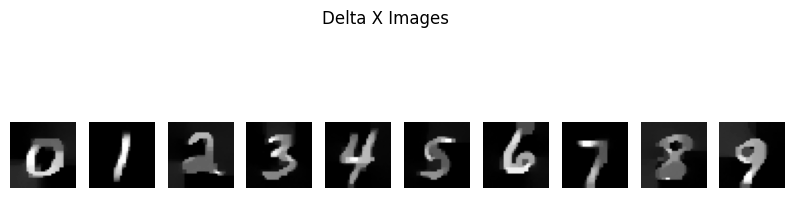

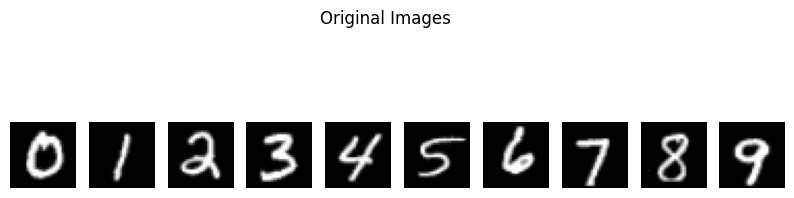

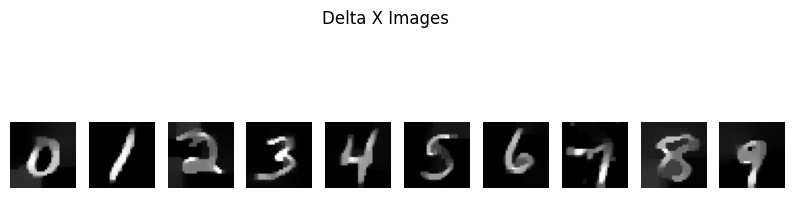

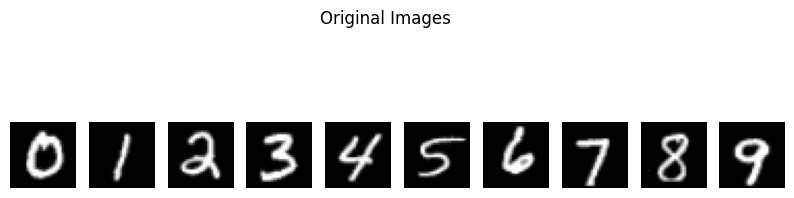

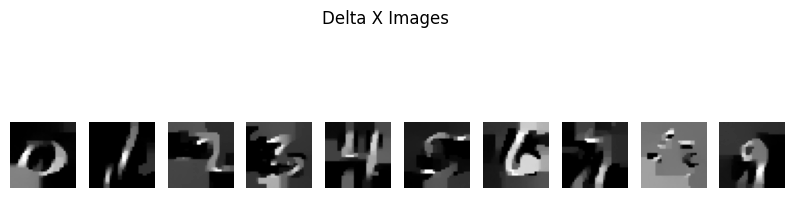

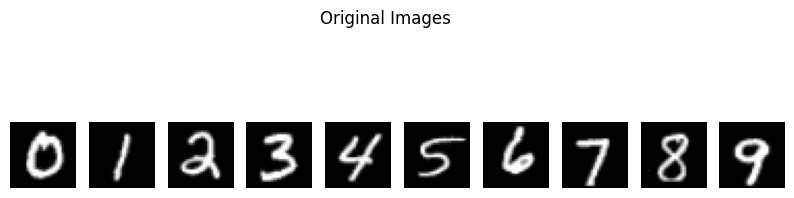

1
done average
done example
done random
2
done average
done example
done random
3
done average
done example
done random
4
done average
done example
done random
Average Class SSIM: 0.30146828293800354 ± 0.0
Class Instance SSIM: 0.24763378500938416 ± 1.4901161193847656e-08
Random Noise SSIM: 0.11431524902582169 ± 0.0024547772482037544

Average Class MSE: 0.060130455574618456 ± 0.0
Class Instance MSE: 0.06871942592430304 ± 0.0
Random Noise MSE: 0.10323632861883728 ± 0.0005011789759980199


In [18]:

# Placeholder lists to store SSIM and MSE values for each initialization method
ssim_values_avg = []
ssim_values_ex = []
ssim_values_rand = []

mse_values_avg = []
mse_values_ex = []
mse_values_rand = []

# Repeat the testing 5 times for each initialization method
for x in range(5):
    print(x)
    ssim1, mean1, x_delta1, images1, indicies = delta_x_testing(0.01, best_l2, best_reg_tv, 400, None, number_dict, average_images_dict,
                                                      loader=shad_val_loader, cnn=shadow_model, inilization='Average_Image')
    
    print("done average")
    ssim2, mean2, x_delta2, images2, _ = delta_x_testing(0.01, best_l2, best_reg_tv, 400, None, number_dict, average_images_dict,
                                                      loader=shad_val_loader, cnn=shadow_model, inilization='Example_Image')
    print("done example")
    ssim3, mean3, x_delta3, images3, _ = delta_x_testing(0.01, best_l2, best_reg_tv, 400, None, number_dict, average_images_dict,
                                                      loader=shad_val_loader, cnn=shadow_model, inilization='Random')
    print("done random")
    
    if x==0:
        plot_delta_x_vs_real(x_delta1, images1, indicies)
        plot_delta_x_vs_real(x_delta2, images2, indicies)
        plot_delta_x_vs_real(x_delta3, images3, indicies)
    # Store the results
    ssim_values_avg.append(ssim1)
    mse_values_avg.append(mean1)
    
    ssim_values_ex.append(ssim2)
    mse_values_ex.append(mean2)
    
    ssim_values_rand.append(ssim3)
    mse_values_rand.append(mean3)

# Calculate the mean and standard deviation for SSIM and MSE for each initialization method
mean_ssim_avg = np.mean(ssim_values_avg)
std_ssim_avg = np.std(ssim_values_avg)

mean_mse_avg = np.mean(mse_values_avg)
std_mse_avg = np.std(mse_values_avg)

mean_ssim_ex = np.mean(ssim_values_ex)
std_ssim_ex = np.std(ssim_values_ex)

mean_mse_ex = np.mean(mse_values_ex)
std_mse_ex = np.std(mse_values_ex)

mean_ssim_rand = np.mean(ssim_values_rand)
std_ssim_rand = np.std(ssim_values_rand)

mean_mse_rand = np.mean(mse_values_rand)
std_mse_rand = np.std(mse_values_rand)

# Print the results
print(f'Average Class SSIM: {mean_ssim_avg} ± {std_ssim_avg}')
print(f'Class Instance SSIM: {mean_ssim_ex} ± {std_ssim_ex}')
print(f'Random Noise SSIM: {mean_ssim_rand} ± {std_ssim_rand}')

print(f'\nAverage Class MSE: {mean_mse_avg} ± {std_mse_avg}')
print(f'Class Instance MSE: {mean_mse_ex} ± {std_mse_ex}')
print(f'Random Noise MSE: {mean_mse_rand} ± {std_mse_rand}')

using test data to be able to compare the SSIM on test data between just gradient reconstructions and the TCNN reconstructions

0
done average
done example
done random


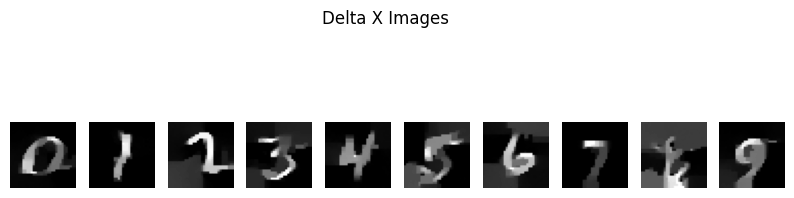

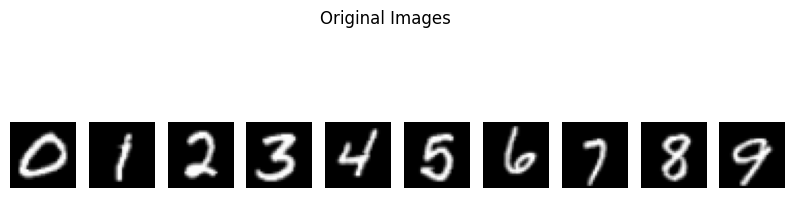

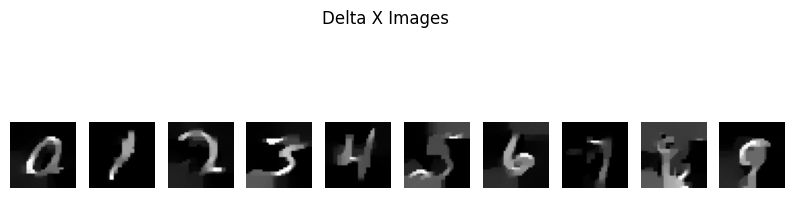

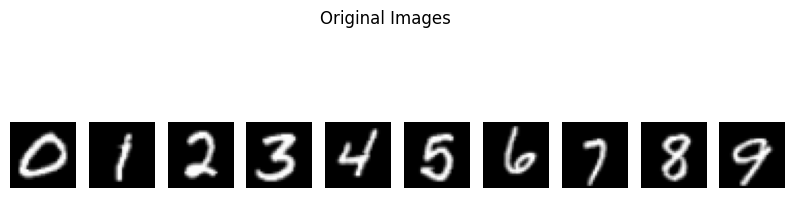

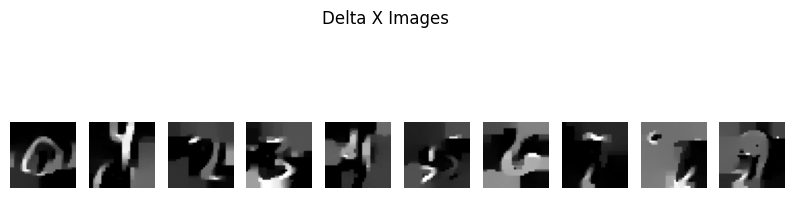

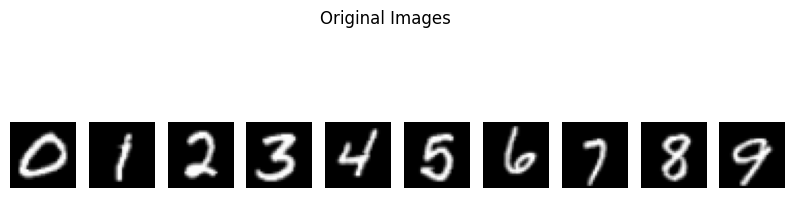

1
done average
done example
done random
2
done average
done example
done random
3
done average
done example
done random
4
done average
done example
done random
Average Class SSIM: 0.24091240763664246 ± 0.0
Class Instance SSIM: 0.18457253277301788 ± 0.0
Random Noise SSIM: 0.07176581770181656 ± 0.0005815785843878984

Average Class MSE: 0.06716609803000605 ± 0.0
Class Instance MSE: 0.07785044566366765 ± 0.0
Random Noise MSE: 0.11368373042611932 ± 0.00025180016834698603


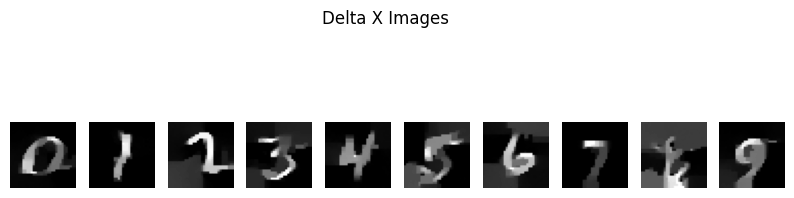

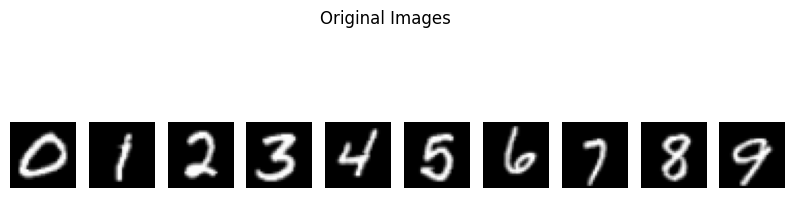

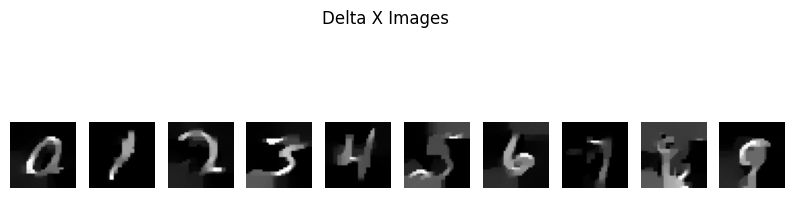

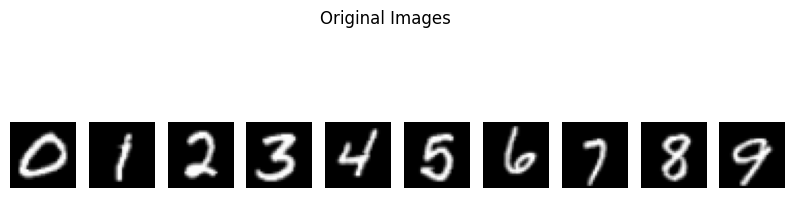

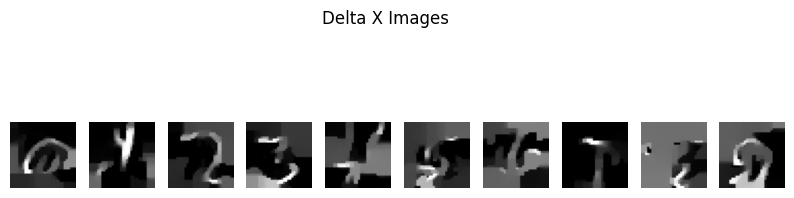

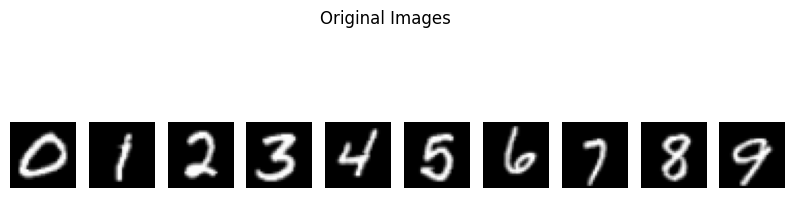

In [19]:
# Placeholder lists to store SSIM and MSE values for each initialization method
ssim_values_avg = []
ssim_values_ex = []
ssim_values_rand = []

mse_values_avg = []
mse_values_ex = []
mse_values_rand = []

# Repeat the testing 5 times for each initialization method
for x in range(5):
    print(x)
    ssim1, mean1, x_delta1, images1, indicies = delta_x_testing(0.01, best_l2, best_reg_tv, 400, None, number_dict, average_images_dict,
                                                  loader=test_loader,cnn=target_model, inilization='Average_Image')
    print("done average")
    ssim2, mean2, x_delta2, images2, _ = delta_x_testing(0.01, best_l2, best_reg_tv, 400, None, number_dict, average_images_dict,
                                                  loader=test_loader, cnn=target_model, inilization='Example_Image')
    print("done example")
    ssim3, mean3, x_delta3, images3, _ = delta_x_testing(0.01, best_l2, best_reg_tv, 400, None, number_dict, average_images_dict,
                                                  loader=test_loader, cnn=target_model, inilization='Random')
    print("done random")
    
    if x==0:
        plot_delta_x_vs_real(x_delta1, images1, indicies)
        plot_delta_x_vs_real(x_delta2, images2, indicies)
        plot_delta_x_vs_real(x_delta3, images3, indicies)
    # Store the results
    ssim_values_avg.append(ssim1)
    mse_values_avg.append(mean1)
    
    ssim_values_ex.append(ssim2)
    mse_values_ex.append(mean2)
    
    ssim_values_rand.append(ssim3)
    mse_values_rand.append(mean3)

# Calculate the mean and standard deviation for SSIM and MSE for each initialization method
mean_ssim_avg = np.mean(ssim_values_avg)
std_ssim_avg = np.std(ssim_values_avg)

mean_mse_avg = np.mean(mse_values_avg)
std_mse_avg = np.std(mse_values_avg)

mean_ssim_ex = np.mean(ssim_values_ex)
std_ssim_ex = np.std(ssim_values_ex)

mean_mse_ex = np.mean(mse_values_ex)
std_mse_ex = np.std(mse_values_ex)

mean_ssim_rand = np.mean(ssim_values_rand)
std_ssim_rand = np.std(ssim_values_rand)

mean_mse_rand = np.mean(mse_values_rand)
std_mse_rand = np.std(mse_values_rand)

# Print the results
print(f'Average Class SSIM: {mean_ssim_avg} ± {std_ssim_avg}')
print(f'Class Instance SSIM: {mean_ssim_ex} ± {std_ssim_ex}')
print(f'Random Noise SSIM: {mean_ssim_rand} ± {std_ssim_rand}')

print(f'\nAverage Class MSE: {mean_mse_avg} ± {std_mse_avg}')
print(f'Class Instance MSE: {mean_mse_ex} ± {std_mse_ex}')
print(f'Random Noise MSE: {mean_mse_rand} ± {std_mse_rand}')



ssim1, mean1, x_delta1, images1, indicies = delta_x_testing(0.01, best_l2, best_reg_tv, 400, None, number_dict, average_images_dict,
                                                  loader=test_loader,cnn=target_model, inilization='Average_Image')
plot_delta_x_vs_real(x_delta1, images1, indicies)

ssim2, mean2, x_delta2, images2, _ = delta_x_testing(0.01, best_l2, best_reg_tv, 400, None, number_dict, average_images_dict,
                                                  loader=test_loader, cnn=target_model, inilization='Example_Image')
plot_delta_x_vs_real(x_delta2, images2, indicies)

ssim3, mean3, x_delta3, images3, _ = delta_x_testing(0.01, best_l2, best_reg_tv, 400, None, number_dict, average_images_dict,
                                                  loader=test_loader, cnn=target_model, inilization='Random')
plot_delta_x_vs_real(x_delta3, images3, indicies)

In [57]:
print(f'Average Class SSIM: {ssim1}')

Average Class SSIM: 0.2527235746383667


In [59]:
print(f'Average Class SSIM: {ssim1} \nClass Instance SSIM: {ssim2}\nRandom Noise SSIM: {ssim3}')
print(f'\nAverage Class MSE: {mean1} \nClass Instance MSE: {mean2}\nRandom Noise MSE: {mean3}')

Average Class SSIM: 0.2527235746383667 
Class Instance SSIM: 0.22519196569919586
Random Noise SSIM: 0.07651235908269882

Average Class MSE: 0.06456793318433103 
Class Instance MSE: 0.06926189721283961
Random Noise MSE: 0.11182617017054068


# Linear Activations & Grad Reconstructions based on Tuned Hyperparamters

## helper functions

In [18]:
def get_outputs(cnn, images, rounding=False, k=10):
    cnn.eval()
    with torch.no_grad():
        outputs = cnn(images) # get y_hat
        if rounding:
              outputs = torch.round(outputs, decimals=1)
        # Get indices of the top 5 elements along the last dimension
        top_k_values, top_k_indices = torch.topk(outputs, k=k, dim=-1)
        # Create a mask tensor where top 5 elements are 1 and the rest are 0
        mask = torch.zeros_like(outputs, dtype=torch.bool)
        mask.scatter_(-1, top_k_indices, 1)
        # Apply the mask to the original tensor
        outputs = torch.where(mask, outputs, torch.zeros_like(outputs))
    return outputs

def activation_extraction(target_outputs, weights_l1, biases_l1, shape):
    # Parameters
    target_outputs = target_outputs.detach().to(device)
    weights_l1 = weights_l1.to(device)
    biases_l1 = biases_l1.to(device)

    weights_l1.requires_grad_(False)
    biases_l1.requires_grad_(False)

    input_vectors = torch.randn(shape, requires_grad=True, device=device)  # Initial random input vector
    # Optimizer
    optimizer = optim.Adam([input_vectors], lr=0.01)  # Optimizing the input vectors
    # Define your loss function
    loss_function = nn.MSELoss()
    batch_loss = float('inf')
    while batch_loss > 1.5:
        optimizer.zero_grad()
        # Generate outputs_delta
        outputs_delta = torch.matmul(input_vectors, weights_l1.T) + biases_l1
        # Calculate loss for the batch
        loss = loss_function(outputs_delta, target_outputs)
        batch_loss = loss.item()
        # Backpropagate to compute gradients with respect to the input vectors
        loss.backward()
        # Update the input vectors
        optimizer.step()

    # Check the output with the optimized input vector
    optimized_outputs = torch.matmul(input_vectors, weights_l1.T) + biases_l1
    optimized_batch_loss = loss_function(optimized_outputs, target_outputs)

    return input_vectors, optimized_outputs, optimized_batch_loss

def x_delta_reconstruction(target_outputs, batch_size, number_dict, average_images_dict, lr=0.01, lambda_reg_l2=0.002, lambda_reg_tv=0.0001, iterations=600, inilization='Average_Image'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if inilization == "Average_Image":
        initial_tensors = get_similar_images(target_outputs, average_images_dict).to(device)
        initial_tensors.requires_grad_(True)
    elif inilization == "Example_Image":
        initial_tensors = get_similar_images(target_outputs, number_dict).to(device)
        initial_tensors.requires_grad_(True)
    else:
        initial_tensors = torch.rand(batch_size, 1, 32, 32, device=device, requires_grad=True)

    loss_fn = nn.MSELoss()
    optimizer = optim.Adam([initial_tensors], lr=lr)
    
    shadow_model.eval()

    for iteration in range(iterations):
        optimizer.zero_grad()
        outputs = shadow_model(initial_tensors)
        loss = loss_fn(outputs, target_outputs)

        reg_loss_l2 = lambda_reg_l2 * torch.sum(initial_tensors ** 2)
        reg_loss_tv = lambda_reg_tv * total_variation_loss(initial_tensors)

        total_loss = loss + reg_loss_l2 + reg_loss_tv
        total_loss.backward()

        torch.nn.utils.clip_grad_norm_(initial_tensors, max_norm=1.0)
        optimizer.step()

        initial_tensors.data.clamp_(0, 1)

        # if iteration % 100 == 0:
        #     print(f'Iteration {iteration}, Loss: {loss.item()}')


    return initial_tensors

In [20]:
class MNIST_adjusted(Dataset):
    def __init__(self, images, labels, activations, x_delta):
        self.images = images
        self.labels = labels
        self.activations = activations
        self.x_delta = x_delta

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        activation = self.activations[idx]
        x_delta = self.x_delta[idx]
        return image, label, activation, x_delta

def process_and_save_dataset(file_path, loader, cnn_model, best_l2, best_reg_tv, iterations=400, lr=0.01, grad_init="Average_Image", rounding=False, k=10, shuffle=False):
    lambda_reg_l2 = best_l2
    lambda_reg_tv = best_reg_tv

    images_list = []
    labels_list = []
    activations_list = []
    x_delta_list = []

    cnn_model.eval()

    layer_weights = cnn_model.layers[15].weight.detach().clone().to(device)
    layer_bias = cnn_model.layers[15].bias.detach().clone().to(device)

    for images, labels in tqdm(loader, desc="A^L and X~ extraction"):
        images, labels = images.to(device), labels.to(device)
        images_list.append(images.cpu())
        labels_list.append(labels.cpu())

        outputs = get_outputs(cnn=cnn_model, images=images, rounding=rounding, k=k)

        #A^L
        input_vectors, optimized_outputs, batch_loss = activation_extraction(outputs, layer_weights, layer_bias, (images.shape[0], layer_weights.shape[1]))
        activations_list.append(input_vectors.detach().cpu())
        #Gradient Reconstructions
        x_deltas = x_delta_reconstruction(outputs, batch_size=images.shape[0], number_dict=number_dict, average_images_dict=average_images_dict,
                                          lr=lr, lambda_reg_l2=lambda_reg_l2, lambda_reg_tv=lambda_reg_tv, iterations=iterations, inilization=grad_init)
        x_delta_list.append(x_deltas.detach().cpu())

    # Combine lists into tensors for Dataset
    images_tensor = torch.cat(images_list, dim=0)
    labels_tensor = torch.cat(labels_list, dim=0)
    activations_tensor = torch.cat(activations_list, dim=0)
    x_delta_tensor = torch.cat(x_delta_list, dim=0)

    # Save into pth file
    mnist_adjusted_dataset = MNIST_adjusted(images_tensor, labels_tensor, activations_tensor, x_delta_tensor)
    dataset_dict = {
        'images': mnist_adjusted_dataset.images,
        'labels': mnist_adjusted_dataset.labels,
        'activations': mnist_adjusted_dataset.activations,
        'x_delta': mnist_adjusted_dataset.x_delta,
    }
    # # Save the dictionary as a single file
    # torch.save(dataset_dict, file_path[i])

    data_loader = DataLoader(mnist_adjusted_dataset, batch_size=batch_size, shuffle=shuffle)
    return data_loader

## get dataloaders with A^L and Grad Reconstructions

In [62]:
# tcnn_train_loader = process_and_save_dataset('/content/drive/My Drive/Thesis_shared/v2/tcnn_train.pth', shadow_loader, shadow_model, best_l2, best_reg_tv, rounding=False, k=10, shuffle=True)
# tcnn_val_loader = process_and_save_dataset('/content/drive/My Drive/Thesis_shared/v2/tcnn_val.pth', shad_val_loader, shadow_model, best_l2, best_reg_tv, rounding=False, k=10, shuffle=False)
# test_loader_v2 = process_and_save_dataset('/content/drive/My Drive/Thesis_shared/v2/test_dataset.pth', test_loader, target_model, best_l2, best_reg_tv, rounding=False, k=10, shuffle=False)

# #Required as A^L and gradient reconstructions based on rounding or truncation
# test_loader_r = process_and_save_dataset('/content/drive/My Drive/Thesis_shared/v2/test_dataset_r.pth', test_loader, target_model, best_l2, best_reg_tv, rounding=True, k=10, shuffle=False)
# test_loader_k5 = process_and_save_dataset('/content/drive/My Drive/Thesis_shared/v2/test_dataset_k5.pth', test_loader, target_model, best_l2, best_reg_tv, rounding=False, k=5, shuffle=False)
# test_loader_k3 = process_and_save_dataset('/content/drive/My Drive/Thesis_shared/v2/test_dataset_k3.pth', test_loader, target_model, best_l2, best_reg_tv, rounding=False, k=3, shuffle=False)
# test_loader_k1 = process_and_save_dataset('/content/drive/My Drive/Thesis_shared/v2/test_dataset_k1.pth', test_loader, target_model, best_l2, best_reg_tv, rounding=False, k=1, shuffle=False)

In [63]:
# tcnn_train_dict = torch.load('/content/drive/My Drive/Thesis_shared/v2/tcnn_train.pth')
# tcnn_val_dict = torch.load('/content/drive/My Drive/Thesis_shared/v2/tcnn_val.pth')
# test_dict = torch.load('/content/drive/My Drive/Thesis_shared/v2/test_dataset.pth')
# test_dict_r = torch.load('/content/drive/My Drive/Thesis_shared/v2/test_dataset_r.pth')
# test_dict_k5 = torch.load('/content/drive/My Drive/Thesis_shared/v2/test_dataset_k5.pth')
# test_dict_k3 = torch.load('/content/drive/My Drive/Thesis_shared/v2/test_dataset_k3.pth')
# test_dict_k1 = torch.load('/content/drive/My Drive/Thesis_shared/v2/test_dataset_k1.pth')

# # dataset instances
# tcnn_train_dataset = MNIST_adjusted(tcnn_train_dict['images'], tcnn_train_dict['labels'], tcnn_train_dict['activations'], tcnn_train_dict['x_delta'],)
# tcnn_val_dataset = MNIST_adjusted(tcnn_val_dict['images'], tcnn_val_dict['labels'], tcnn_val_dict['activations'], tcnn_val_dict['x_delta'],)
# test_dataset_v2 = MNIST_adjusted(test_dict['images'], test_dict['labels'], test_dict['activations'], test_dict['x_delta'],)
# test_dataset_r = MNIST_adjusted(test_dict_r['images'], test_dict_r['labels'], test_dict_r['activations'], test_dict_r['x_delta'],)
# test_dataset_k5 = MNIST_adjusted(test_dict_k5['images'], test_dict_k5['labels'], test_dict_k5['activations'], test_dict_k5['x_delta'],)
# test_dataset_k3 = MNIST_adjusted(test_dict_k3['images'], test_dict_k3['labels'], test_dict_k3['activations'], test_dict_k3['x_delta'],)
# test_dataset_k1 = MNIST_adjusted(test_dict_k1['images'], test_dict_k1['labels'], test_dict_k1['activations'], test_dict_k1['x_delta'],)
# # dataloaders
# tcnn_train_loader = DataLoader(tcnn_train_dataset, batch_size=batch_size, shuffle=True)
# tcnn_val_loader = DataLoader(tcnn_val_dataset, batch_size=batch_size, shuffle=False)
# test_loader_v2 = DataLoader(test_dataset_v2, batch_size=batch_size, shuffle=False)
# test_loader_r = DataLoader(test_dataset_r, batch_size=batch_size, shuffle=False)
# test_loader_k5 = DataLoader(test_dataset_k5, batch_size=batch_size, shuffle=False)
# test_loader_k3 = DataLoader(test_dataset_k3, batch_size=batch_size, shuffle=False)
# test_loader_k1 = DataLoader(test_dataset_k1, batch_size=batch_size, shuffle=False)

# TCNN's

## TCNN Helper functions

In [21]:
def extend_outputs(images, labels, feature_map, x_delta, cnn, feature_num=10,
                   rounding=False, k=10, use_output_vector=True, use_activations=False, use_xd=False):
    features = get_outputs(cnn, images, rounding, k) if use_output_vector else None # refer to learning loops section

    # add additional info to features based on current TCNN
    if use_activations:
        if features is None:
            features = feature_map
        else:
            features = torch.cat((features, feature_map), dim=1)
    if use_xd:
        flattened_x_delta = x_delta.view(x_delta.shape[0], -1)
        if features is None:
            features = flattened_x_delta
        else:
            features = torch.cat((features, flattened_x_delta), dim=1)

    # transpose to shape required by TCNN
    features = features.view(-1, feature_num, 1, 1)

    return features

In [22]:
def test_set_evaluation(tcnn_model, loader,cur_feature_num, k, r, use_output_vec, use_activ, use_delta):
    target_model.eval()
    tcnn_model.eval()

    reconstructed_list = []
    images_list = []
    ssim_values = [] # stores average values over batch
    mse_values = [] # stores average values over batch
    labels_lst = []

    criterion = SSIM(win_size=11, win_sigma=1.5, data_range=1, size_average=False, channel=1)
    mse_loss = nn.MSELoss()

    for images, labels, activations, x_deltas in loader:
        images, activations, x_deltas = images.to(device), activations.to(device), x_deltas.to(device)
        labels_lst.extend(labels.tolist())

        with torch.no_grad():
            features = extend_outputs(images, labels, activations, x_deltas, target_model, cur_feature_num,
                                      rounding=r, k=k, use_output_vector=use_output_vec, use_activations=use_activ, use_xd=use_delta)
            reconstructed_images = tcnn_model(features)

            ssim_batch = criterion(reconstructed_images.to('cpu'), images.to('cpu'))
            mse_batch = [mse_loss(reconstructed_images[j].to('cpu'), images[j].to('cpu')).item() for j in range(images.shape[0])]

            ssim_values.extend(ssim_batch)
            mse_values.extend(mse_batch)

        # obtain x_deltas
        reconstructed_list.append(reconstructed_images.detach().cpu())
        images_list.append(images.detach().cpu())


    reconstructed_tensor = torch.cat(reconstructed_list, dim=0)
    images_tensor = torch.cat(images_list, dim=0)

    # Get {class: (SSIM, Index)}
    highest_ssim_per_class = {cls: (float('-inf'), 0) for cls in range(10)}
    for idx, (cls, ssim) in enumerate(zip(labels_lst, ssim_values)):
        if ssim > highest_ssim_per_class[cls][0]:
            highest_ssim_per_class[cls] = (ssim, idx)

    # get the index for max ssim value per class
    highest_ssim_indices = [highest_ssim_per_class[cls][1] for cls in highest_ssim_per_class]

    return np.mean(ssim_values), np.mean(mse_values), reconstructed_tensor, images_tensor, highest_ssim_indices

## Best Model Config finding

In [24]:
def run_experiment_2(models_configs, num_repeats, same_images=False, truncation_bool=False, rounding_bool=False, validation_bool=True):
    all_results = {config['name']: {'ssim': [], 'mse': []} for config in models_configs}
    
    if truncation_bool == False:
            train_loader = process_and_save_dataset('tcnn_train.pth', shadow_loader, shadow_model, best_l2, best_reg_tv, rounding=False, k=10, shuffle=True)
    if rounding_bool == False and truncation_bool == False:
        val_loader = process_and_save_dataset('tcnn_val.pth', shad_val_loader, shadow_model, best_l2, best_reg_tv, rounding=False, k=10, shuffle=False)
        if not validation_bool:
            test_loader_v2 = process_and_save_dataset('test_dataset.pth', test_loader, target_model, best_l2, best_reg_tv, rounding=False, k=10, shuffle=False)

    for config in models_configs:
        name = config['name']
        feature_num = config['feature_num']
        k = config['k']
        r = config['r']
        use_output_vec = config['use_output_vec']
        use_map = config['use_map']
        use_delta = config['use_delta']
        
        if truncation_bool:
            print("here")
            train_loader = process_and_save_dataset('/content/drive/My Drive/Thesis_shared/v2/tcnn_train.pth', shadow_loader, shadow_model, best_l2, best_reg_tv, rounding=False, k=k, shuffle=True)
            val_loader = process_and_save_dataset('/content/drive/My Drive/Thesis_shared/v2/tcnn_val.pth', shad_val_loader, shadow_model, best_l2, best_reg_tv, rounding=False, k=k, shuffle=False)
            if not validation_bool:
                test_loader_v2 = process_and_save_dataset('/content/drive/My Drive/Thesis_shared/v2/test_dataset.pth', test_loader, target_model, best_l2, best_reg_tv, rounding=False, k=k, shuffle=False)

        if rounding_bool:
            val_loader = process_and_save_dataset('/content/drive/My Drive/Thesis_shared/v2/tcnn_val.pth', shad_val_loader, shadow_model, best_l2, best_reg_tv, rounding=r, k=10, shuffle=False)
            if not validation_bool:
                test_loader_v2 = process_and_save_dataset('/content/drive/My Drive/Thesis_shared/v2/test_dataset.pth', test_loader, target_model, best_l2, best_reg_tv, rounding=r, k=10, shuffle=False)

                
        for i in range(num_repeats):
            print(f"name {name}. iteration {i}")

            tcnn = TCNN(input_channels=feature_num, hidden_sizes=[512, 256, 128],
                        hidden_activation_func=nn.Tanh, output_color_channels=1).to(device)

            training_tcnn(tcnn, shadow_model, num_features=feature_num, data_range=1, channels=1,
                          training_dataloader=train_loader, validation_dataloader=val_loader,
                          num_epochs=epochs_tcnn, top_k=k, rounding=False, use_output_vector=use_output_vec, use_map=use_map, use_x_delta=use_delta)

            avg_ssim, avg_mse, reconstructions, i_tensors, indicies = test_set_evaluation(tcnn, val_loader if validation_bool else test_loader_v2, feature_num, k, r, use_output_vec, use_map, use_delta) # get scores for validation set
            all_results[config['name']]['ssim'].append(avg_ssim)
            all_results[config['name']]['mse'].append(avg_mse)

            if same_images and i == 0 and name in ('TCNN_dx_no_rounding', 'F_dx_k10','F_o_k10'):
                best_indicies = indicies

            if i == 0:
                plot_delta_x_vs_real(reconstructions, i_tensors, best_indicies if same_images else indicies)

    for config in models_configs:
        name = config['name']
        mean_ssim = np.mean(all_results[name]['ssim'])
        std_ssim = np.std(all_results[name]['ssim'])
        mean_mse = np.mean(all_results[name]['mse'])
        std_mse = np.std(all_results[name]['mse'])

        txt = "validation" if validation_bool else "test"
        print(f'{name}: Average SSIM on {txt} set: {round(mean_ssim, 4)} ± {round(std_ssim, 4)}, '
              f'Average MSE on {txt} set: {round(mean_mse, 4)} ± {round(std_mse, 4)}')
        


A^L and X~ extraction: 100%|██████████| 42/42 [01:38<00:00,  2.35s/it]


name TCNN_O. iteration 0
Epoch 20/20, Train Loss: 0.4110, Val Loss: 0.3943


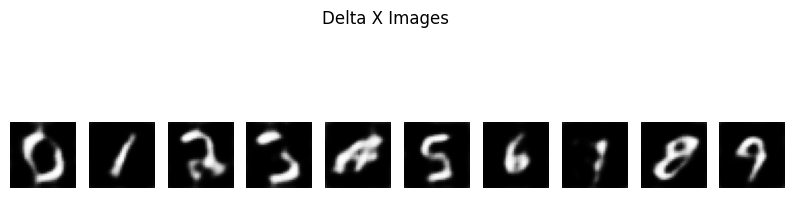

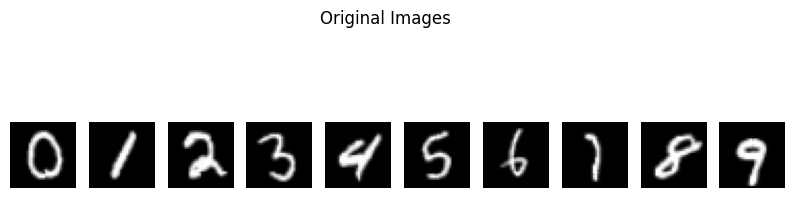

name TCNN_O. iteration 1
Epoch 20/20, Train Loss: 0.4104, Val Loss: 0.3916
name TCNN_O. iteration 2
Epoch 20/20, Train Loss: 0.4116, Val Loss: 0.3922
name TCNN_O. iteration 3
Epoch 20/20, Train Loss: 0.4108, Val Loss: 0.3928
name TCNN_O. iteration 4
Epoch 20/20, Train Loss: 0.4118, Val Loss: 0.3959
name TCNN_fm. iteration 0
Epoch 20/20, Train Loss: 0.4037, Val Loss: 0.4033


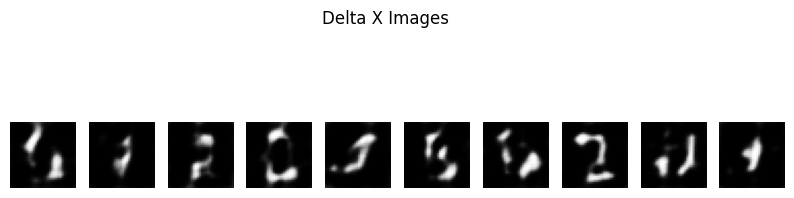

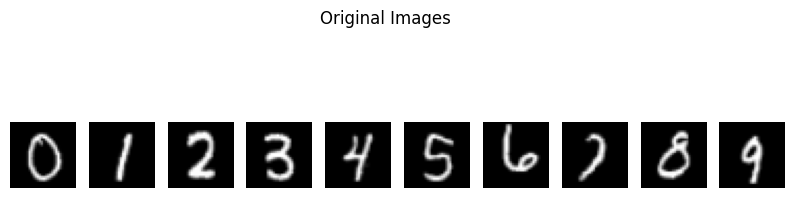

name TCNN_fm. iteration 1
Epoch 20/20, Train Loss: 0.4039, Val Loss: 0.4068
name TCNN_fm. iteration 2
Epoch 20/20, Train Loss: 0.4030, Val Loss: 0.4046
name TCNN_fm. iteration 3
Epoch 20/20, Train Loss: 0.4034, Val Loss: 0.4050
name TCNN_fm. iteration 4
Epoch 20/20, Train Loss: 0.4029, Val Loss: 0.4038
name TCNN_dx. iteration 0
Epoch 20/20, Train Loss: 0.4108, Val Loss: 0.4242


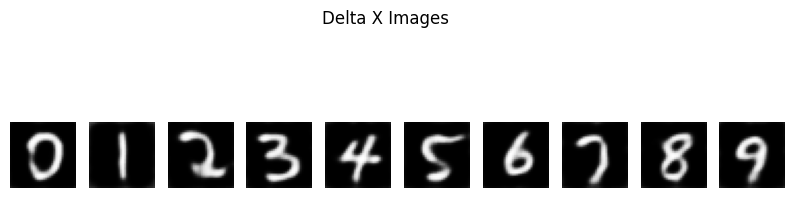

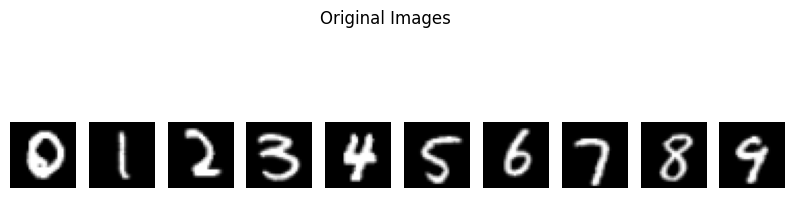

name TCNN_dx. iteration 1
Epoch 20/20, Train Loss: 0.4101, Val Loss: 0.4295
name TCNN_dx. iteration 2
Epoch 20/20, Train Loss: 0.4098, Val Loss: 0.4256
name TCNN_dx. iteration 3
Epoch 20/20, Train Loss: 0.4105, Val Loss: 0.4263
name TCNN_dx. iteration 4
Epoch 20/20, Train Loss: 0.4103, Val Loss: 0.4225
name TCNN_o_fm. iteration 0
Epoch 20/20, Train Loss: 0.4005, Val Loss: 0.3986


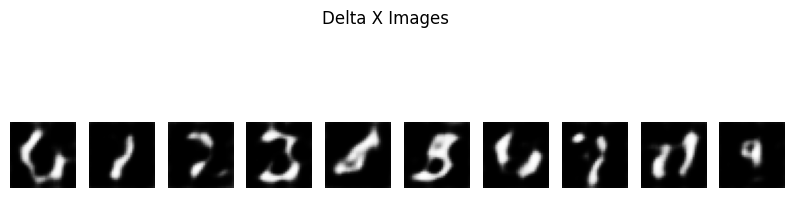

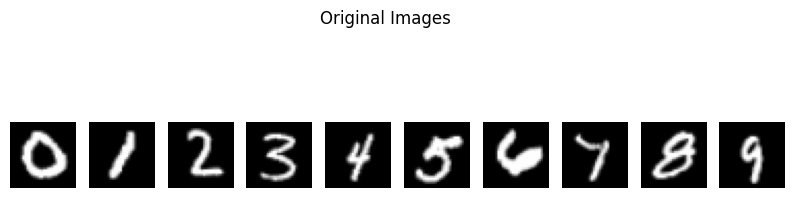

name TCNN_o_fm. iteration 1
Epoch 20/20, Train Loss: 0.3999, Val Loss: 0.3986
name TCNN_o_fm. iteration 2
Epoch 20/20, Train Loss: 0.3990, Val Loss: 0.3968
name TCNN_o_fm. iteration 3
Epoch 20/20, Train Loss: 0.3992, Val Loss: 0.3987
name TCNN_o_fm. iteration 4
Epoch 20/20, Train Loss: 0.3998, Val Loss: 0.3968
name TCNN_o_dx. iteration 0
Epoch 20/20, Train Loss: 0.3892, Val Loss: 0.3961


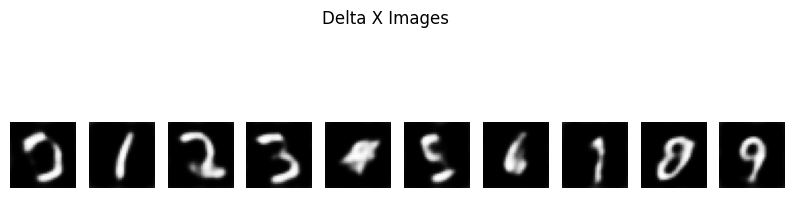

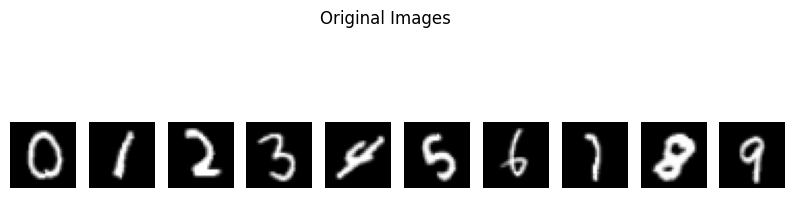

name TCNN_o_dx. iteration 1
Epoch 20/20, Train Loss: 0.3887, Val Loss: 0.3988
name TCNN_o_dx. iteration 2
Epoch 20/20, Train Loss: 0.3896, Val Loss: 0.3931
name TCNN_o_dx. iteration 3
Epoch 20/20, Train Loss: 0.3884, Val Loss: 0.3962
name TCNN_o_dx. iteration 4
Epoch 20/20, Train Loss: 0.3879, Val Loss: 0.3956
name TCNN_fm_dx. iteration 0
Epoch 20/20, Train Loss: 0.3839, Val Loss: 0.3935


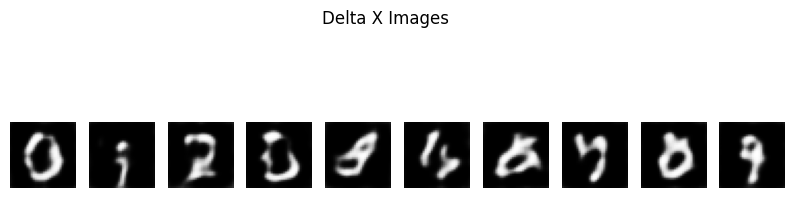

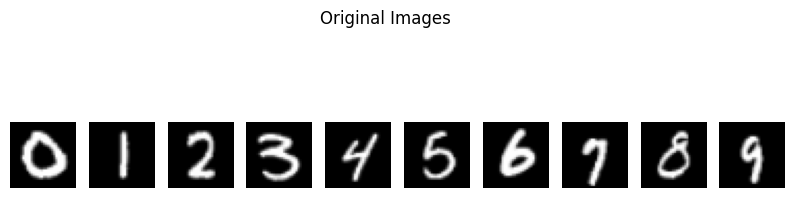

name TCNN_fm_dx. iteration 1
Epoch 20/20, Train Loss: 0.3841, Val Loss: 0.3957
name TCNN_fm_dx. iteration 2
Epoch 20/20, Train Loss: 0.3831, Val Loss: 0.3918
name TCNN_fm_dx. iteration 3
Epoch 20/20, Train Loss: 0.3834, Val Loss: 0.3976
name TCNN_fm_dx. iteration 4
Epoch 20/20, Train Loss: 0.3835, Val Loss: 0.4011
name TCNN_o_fm_dx. iteration 0
Epoch 20/20, Train Loss: 0.3846, Val Loss: 0.3909


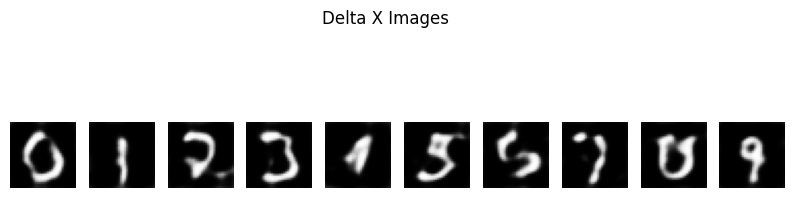

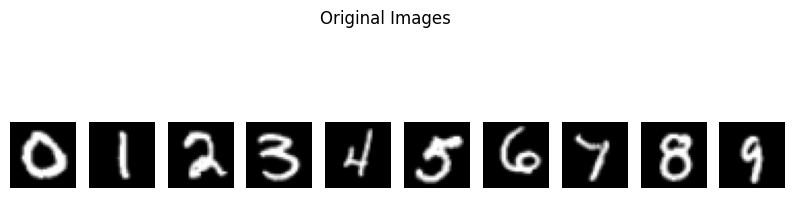

name TCNN_o_fm_dx. iteration 1
Epoch 20/20, Train Loss: 0.3852, Val Loss: 0.3919
name TCNN_o_fm_dx. iteration 2
Epoch 20/20, Train Loss: 0.3852, Val Loss: 0.3916
name TCNN_o_fm_dx. iteration 3
Epoch 20/20, Train Loss: 0.3845, Val Loss: 0.3891
name TCNN_o_fm_dx. iteration 4
Epoch 20/20, Train Loss: 0.3845, Val Loss: 0.3924
TCNN_O: Average SSIM on test set: 0.2298000007867813 ± 0.004100000020116568, Average MSE on test set: 0.0966 ± 0.0011
TCNN_fm: Average SSIM on test set: 0.121799997985363 ± 0.00430000014603138, Average MSE on test set: 0.1077 ± 0.0014
TCNN_dx: Average SSIM on test set: 0.3727000057697296 ± 0.003000000026077032, Average MSE on test set: 0.0649 ± 0.0004
TCNN_o_fm: Average SSIM on test set: 0.16189999878406525 ± 0.0008999999845400453, Average MSE on test set: 0.1055 ± 0.0008
TCNN_o_dx: Average SSIM on test set: 0.2467000037431717 ± 0.0013000000035390258, Average MSE on test set: 0.0904 ± 0.0013
TCNN_fm_dx: Average SSIM on test set: 0.18219999969005585 ± 0.005100000184029

In [94]:
models_configs = [
    {'name': 'TCNN_O', 'feature_num': 10, 'k': 10, 'r': False, 'use_output_vec': True, 'use_map': False, 'use_delta': False},
    {'name': 'TCNN_fm', 'feature_num': layer_weights.shape[1], 'k': 10, 'r': False, 'use_output_vec': False, 'use_map': True, 'use_delta': False},
    {'name': 'TCNN_dx', 'feature_num': 1024, 'k': 10, 'r': False, 'use_output_vec': False, 'use_map': False, 'use_delta': True},
    {'name': 'TCNN_o_fm', 'feature_num': 10 + layer_weights.shape[1], 'k': 10, 'r': False, 'use_output_vec': True, 'use_map': True, 'use_delta': False},
    {'name': 'TCNN_o_dx', 'feature_num': 10 + 1024, 'k': 10, 'r': False, 'use_output_vec': True, 'use_map': False, 'use_delta': True},
    {'name': 'TCNN_fm_dx', 'feature_num': layer_weights.shape[1] + 1024, 'k': 10, 'r': False, 'use_output_vec': False, 'use_map': True, 'use_delta': True},
    {'name': 'TCNN_o_fm_dx', 'feature_num': 10 + layer_weights.shape[1] + 1024, 'k': 10, 'r': False, 'use_output_vec': True, 'use_map': True, 'use_delta': True}
]
# obtain SSIM and MSE on validation set
run_experiment_2(models_configs, num_repeats=5, validation_bool=False) #1.25 hours

## Best Model Config Obtain Test Results

In [69]:
# models_configs = [
#     {'name': 'TCNN_dx', 'feature_num': 1024, 'k': 10, 'r': False, 'use_output_vec': False, 'use_map': False, 'use_delta': True},
# ]

# run_experiment(models_configs, num_repeats=5, validation_bool=False) #obtain the SSIM and MSE scores on Test Set

## Rounding Experiment

A^L and X~ extraction: 100%|██████████| 42/42 [01:39<00:00,  2.37s/it]


name TCNN_dx_no_rounding. iteration 0
Epoch 20/20, Train Loss: 0.4088, Val Loss: 0.4288


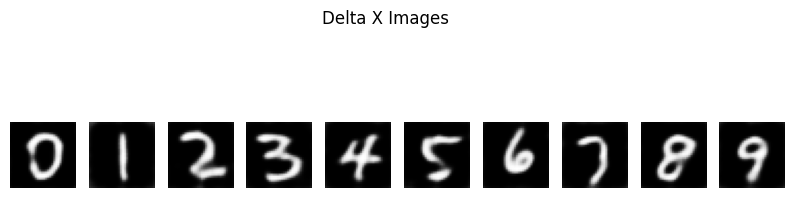

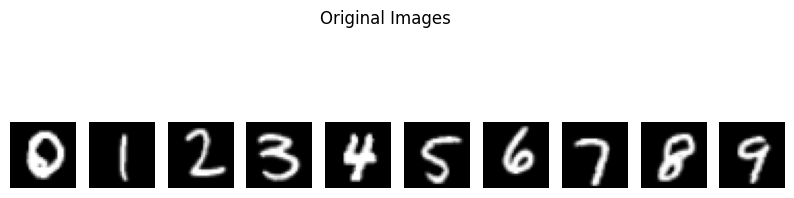

name TCNN_dx_no_rounding. iteration 1
Epoch 20/20, Train Loss: 0.4085, Val Loss: 0.4241
name TCNN_dx_no_rounding. iteration 2
Epoch 20/20, Train Loss: 0.4101, Val Loss: 0.4255
name TCNN_dx_no_rounding. iteration 3
Epoch 20/20, Train Loss: 0.4093, Val Loss: 0.4260
name TCNN_dx_no_rounding. iteration 4
Epoch 20/20, Train Loss: 0.4088, Val Loss: 0.4225


A^L and X~ extraction: 100%|██████████| 42/42 [01:39<00:00,  2.37s/it]


name TCNN_dx_rounding. iteration 0
Epoch 20/20, Train Loss: 0.4085, Val Loss: 0.4241


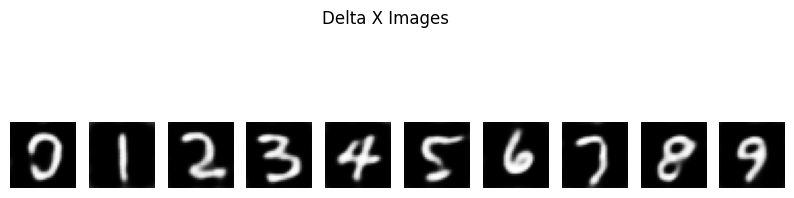

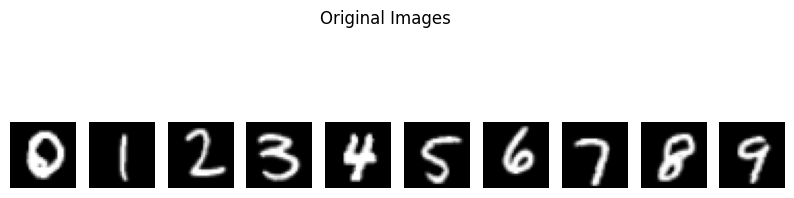

name TCNN_dx_rounding. iteration 1
Epoch 20/20, Train Loss: 0.4092, Val Loss: 0.4290
name TCNN_dx_rounding. iteration 2
Epoch 20/20, Train Loss: 0.4091, Val Loss: 0.4245
name TCNN_dx_rounding. iteration 3
Epoch 20/20, Train Loss: 0.4099, Val Loss: 0.4237
name TCNN_dx_rounding. iteration 4
Epoch 20/20, Train Loss: 0.4089, Val Loss: 0.4285


A^L and X~ extraction: 100%|██████████| 42/42 [01:39<00:00,  2.37s/it]


name Baseline_no_rounding. iteration 0
Epoch 20/20, Train Loss: 0.4113, Val Loss: 0.3890


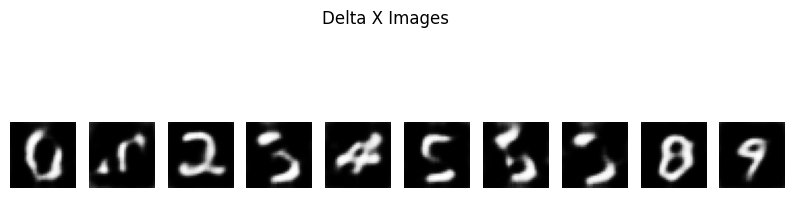

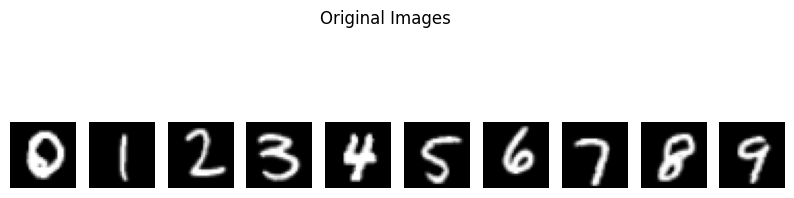

name Baseline_no_rounding. iteration 1
Epoch 20/20, Train Loss: 0.4104, Val Loss: 0.3926
name Baseline_no_rounding. iteration 2
Epoch 20/20, Train Loss: 0.4089, Val Loss: 0.3895
name Baseline_no_rounding. iteration 3
Epoch 20/20, Train Loss: 0.4107, Val Loss: 0.3930
name Baseline_no_rounding. iteration 4
Epoch 20/20, Train Loss: 0.4106, Val Loss: 0.3894


A^L and X~ extraction: 100%|██████████| 42/42 [01:38<00:00,  2.35s/it]


name Baseline_rounding. iteration 0
Epoch 20/20, Train Loss: 0.4101, Val Loss: 0.3900


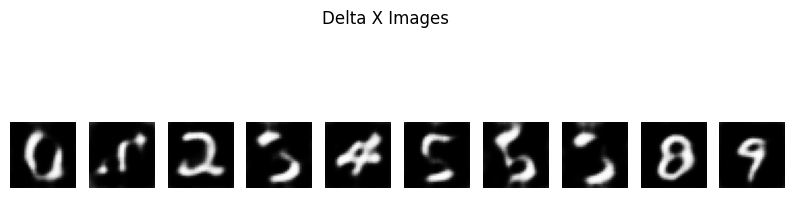

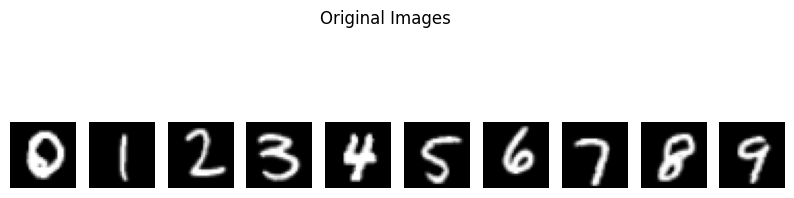

name Baseline_rounding. iteration 1
Epoch 20/20, Train Loss: 0.4105, Val Loss: 0.3906
name Baseline_rounding. iteration 2
Epoch 20/20, Train Loss: 0.4102, Val Loss: 0.3933
name Baseline_rounding. iteration 3
Epoch 20/20, Train Loss: 0.4099, Val Loss: 0.3894
name Baseline_rounding. iteration 4
Epoch 20/20, Train Loss: 0.4115, Val Loss: 0.3912
TCNN_dx_no_rounding: Average SSIM on test set: 0.3720000088214874 ± 0.00430000014603138, Average MSE on test set: 0.0659 ± 0.0005
TCNN_dx_rounding: Average SSIM on test set: 0.3716000020503998 ± 0.006000000052154064, Average MSE on test set: 0.0658 ± 0.0013
Baseline_no_rounding: Average SSIM on test set: 0.22869999706745148 ± 0.0005000000237487257, Average MSE on test set: 0.0977 ± 0.0012
Baseline_rounding: Average SSIM on test set: 0.23160000145435333 ± 0.0024999999441206455, Average MSE on test set: 0.0965 ± 0.0015


In [91]:
models_configs = [
    {'name': 'TCNN_dx_no_rounding', 'feature_num': 1024, 'k': 10, 'r': False, 'use_output_vec': False, 'use_map': False, 'use_delta': True},
    {'name': 'TCNN_dx_rounding', 'feature_num': 1024, 'k': 10, 'r': True, 'use_output_vec': False, 'use_map': False, 'use_delta': True},
    {'name': 'Baseline_no_rounding', 'feature_num': 10, 'k': 10, 'r': False, 'use_output_vec': True, 'use_map': False, 'use_delta': False},
    {'name': 'Baseline_rounding', 'feature_num': 10, 'k': 10, 'r': True, 'use_output_vec': True, 'use_map': False, 'use_delta': False}
]

run_experiment_2(models_configs, num_repeats=5,same_images=True,
               truncation_bool=False, rounding_bool=True, validation_bool=False) #1.25 hours

## Truncation experiment

here


A^L and X~ extraction: 100%|██████████| 42/42 [01:38<00:00,  2.34s/it]


name F_dx_k10. iteration 0
Epoch 20/20, Train Loss: 0.4101, Val Loss: 0.4243


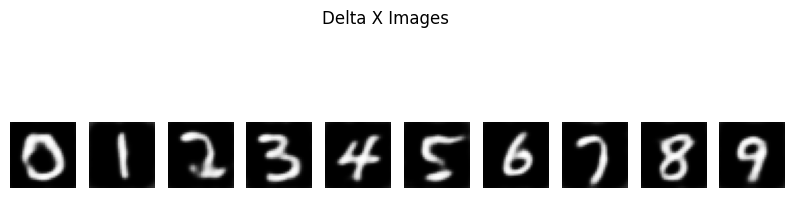

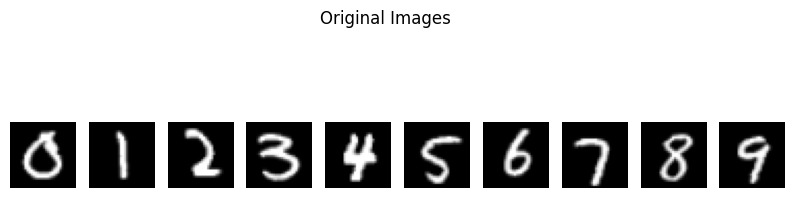

name F_dx_k10. iteration 1
Epoch 20/20, Train Loss: 0.4101, Val Loss: 0.4221
name F_dx_k10. iteration 2
Epoch 20/20, Train Loss: 0.4101, Val Loss: 0.4245
name F_dx_k10. iteration 3
Epoch 20/20, Train Loss: 0.4104, Val Loss: 0.4230
name F_dx_k10. iteration 4
Epoch 20/20, Train Loss: 0.4093, Val Loss: 0.4243
here


A^L and X~ extraction: 100%|██████████| 42/42 [01:36<00:00,  2.30s/it]


name F_dx_k5. iteration 0
Epoch 20/20, Train Loss: 0.4931, Val Loss: 0.5012


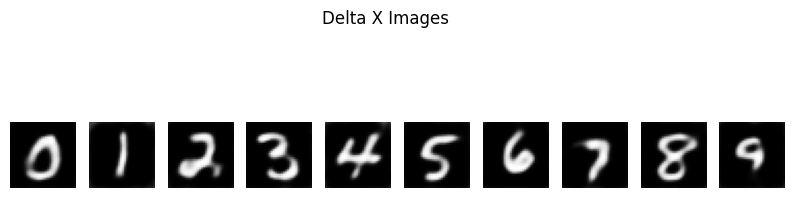

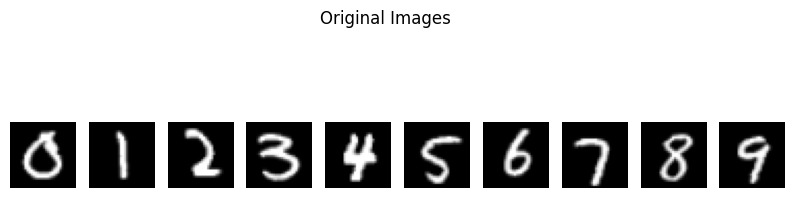

name F_dx_k5. iteration 1
Epoch 20/20, Train Loss: 0.4929, Val Loss: 0.4999
name F_dx_k5. iteration 2
Epoch 20/20, Train Loss: 0.4937, Val Loss: 0.5030
name F_dx_k5. iteration 3
Epoch 20/20, Train Loss: 0.4923, Val Loss: 0.4991
name F_dx_k5. iteration 4
Epoch 20/20, Train Loss: 0.4933, Val Loss: 0.5031
here


A^L and X~ extraction: 100%|██████████| 42/42 [01:36<00:00,  2.30s/it]


name F_dx_k3. iteration 0
Epoch 20/20, Train Loss: 0.5109, Val Loss: 0.5234


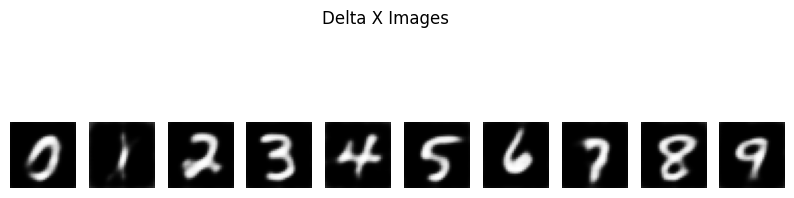

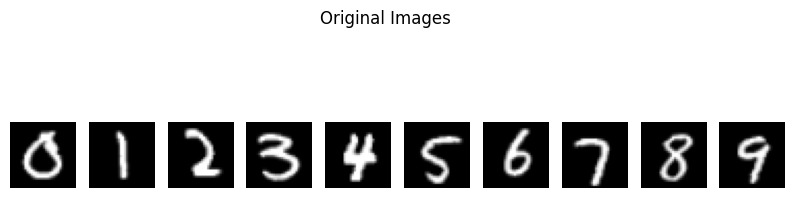

name F_dx_k3. iteration 1
Epoch 20/20, Train Loss: 0.5113, Val Loss: 0.5216
name F_dx_k3. iteration 2
Epoch 20/20, Train Loss: 0.5107, Val Loss: 0.5205
name F_dx_k3. iteration 3
Epoch 20/20, Train Loss: 0.5114, Val Loss: 0.5194
name F_dx_k3. iteration 4
Epoch 20/20, Train Loss: 0.5109, Val Loss: 0.5198
here


A^L and X~ extraction: 100%|██████████| 42/42 [01:37<00:00,  2.32s/it]


name F_dx_k1. iteration 0
Epoch 20/20, Train Loss: 0.5628, Val Loss: 0.5577


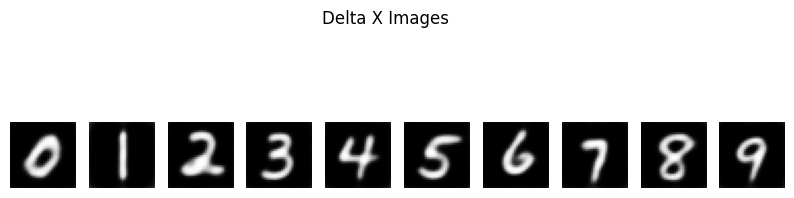

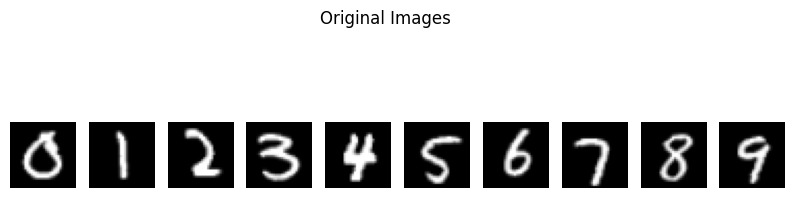

name F_dx_k1. iteration 1
Epoch 20/20, Train Loss: 0.5627, Val Loss: 0.5583
name F_dx_k1. iteration 2
Epoch 20/20, Train Loss: 0.5625, Val Loss: 0.5598
name F_dx_k1. iteration 3
Epoch 20/20, Train Loss: 0.5626, Val Loss: 0.5571
name F_dx_k1. iteration 4
Epoch 20/20, Train Loss: 0.5626, Val Loss: 0.5594
F_dx_k10: Average SSIM on test set: 0.37470000982284546 ± 0.001500000013038516, Average MSE on test set: 0.0649 ± 0.0006
F_dx_k5: Average SSIM on test set: 0.4083999991416931 ± 0.00139999995008111, Average MSE on test set: 0.0588 ± 0.0003
F_dx_k3: Average SSIM on test set: 0.4171999990940094 ± 0.0027000000700354576, Average MSE on test set: 0.0572 ± 0.0005
F_dx_k1: Average SSIM on test set: 0.4296000003814697 ± 0.0017000000225380063, Average MSE on test set: 0.0548 ± 0.0005


In [92]:
models_configs = [
    {'name': 'F_dx_k10', 'feature_num': 1024, 'k': 10, 'r': False, 'use_output_vec': False, 'use_map': False, 'use_delta': True},
    {'name': 'F_dx_k5', 'feature_num': 1024, 'k': 5, 'r': False, 'use_output_vec': False, 'use_map': False, 'use_delta': True},
    {'name': 'F_dx_k3', 'feature_num': 1024, 'k': 3, 'r': False, 'use_output_vec': False, 'use_map': False, 'use_delta': True},
    {'name': 'F_dx_k1', 'feature_num': 1024, 'k': 1, 'r': False, 'use_output_vec': False, 'use_map': False, 'use_delta': True}
]

run_experiment_2(models_configs, num_repeats=5,same_images=True,
               truncation_bool=True, rounding_bool=False, validation_bool=False) #1.25 hours#6 hours

In [ ]:
models_configs = [
    {'name': 'F_o_k10', 'feature_num': 10, 'k': 10, 'r': False, 'use_output_vec': True, 'use_map': False, 'use_delta': False},
    {'name': 'F_o_k5', 'feature_num': 10, 'k': 5, 'r': False, 'use_output_vec': True, 'use_map': False, 'use_delta': False},
    {'name': 'F_o_k3', 'feature_num': 10, 'k': 3, 'r': False, 'use_output_vec': True, 'use_map': False, 'use_delta': False},
    {'name': 'F_o_k1', 'feature_num': 10, 'k': 1, 'r': False, 'use_output_vec': True, 'use_map': False, 'use_delta': False}
]

run_experiment_2(models_configs, num_repeats=5,same_images=True,
               truncation_bool=True, rounding_bool=False, validation_bool=False) #1

here


A^L and X~ extraction:   2%|▏         | 5/313 [00:21<21:57,  4.28s/it]